In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as fn
from pyspark.ml import feature
from pyspark.ml import classification
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show
import seaborn as sns

from scipy.stats import norm

from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row


## Open SparkSession & Import the Dataset

In [3]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [4]:
%fs ls FileStore/tables

path,name,size
dbfs:/FileStore/tables/01_01.sql,01_01.sql,1258
dbfs:/FileStore/tables/01_03.sql,01_03.sql,1158
dbfs:/FileStore/tables/LISTING417.csv,LISTING417.csv,21278642
dbfs:/FileStore/tables/airbnb_final_2__1_-599f7.ipynb,airbnb_final_2__1_-599f7.ipynb,20656
dbfs:/FileStore/tables/bankdata_csv_all.csv,bankdata_csv_all.csv,34566
dbfs:/FileStore/tables/cogsley_clients.csv,cogsley_clients.csv,384219
dbfs:/FileStore/tables/cogsley_sales.csv,cogsley_sales.csv,2176442
dbfs:/FileStore/tables/detailed_listings-347ac.csv,detailed_listings-347ac.csv,182544196
dbfs:/FileStore/tables/hour.csv,hour.csv,1138563
dbfs:/FileStore/tables/listing417final.csv,listing417final.csv,21293591


In [5]:
#sparkDF = spark.read.format('csv').options(header='true').load('FileStore/tables/LISTING417.csv')
#display(sparkDF)

In [6]:
#pandas_df = sparkDF.toPandas()
#pandas_df

In [7]:
pandas_df = pd.read_csv("/dbfs/FileStore/tables/listing417finalfinal.csv", error_bad_lines=False, encoding = "ISO-8859-1")
#pandas_df = pd.read_csv("/dbfs/FileStore/tables/listing417final_thelast.csv", error_bad_lines=False, encoding = "ISO-8859-1")


pandas_df
#finalfianl.csv
#thelast.csv

b'Skipping line 25362: expected 25 fields, saw 29\nSkipping line 25393: expected 25 fields, saw 29\nSkipping line 25397: expected 25 fields, saw 29\nSkipping line 29211: expected 25 fields, saw 27\nSkipping line 31931: expected 25 fields, saw 26\nSkipping line 32186: expected 25 fields, saw 27\n'
b'Skipping line 37226: expected 25 fields, saw 40\nSkipping line 37250: expected 25 fields, saw 40\nSkipping line 37315: expected 25 fields, saw 40\nSkipping line 38036: expected 25 fields, saw 33\nSkipping line 39270: expected 25 fields, saw 40\nSkipping line 44518: expected 25 fields, saw 40\n'
/databricks/python/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2741: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
 interactivity=interactivity, compiler=compiler)
 Out[ 148 ]: 
 id summary host_id \
0 2515 Step into our artistic spacious apartment and ... 2758 
1 21456 An adorable, classic, clean, light-filled one-... 42032 
2 2539 Renovated apt home in elevator building. 2787 
3 2595 Find your romantic getaway to this beautiful, ... 2845 
4 21644 A great space in a beautiful neighborhood- min... 82685 
5 3330 This is a spacious, clean, furnished master be... 4177 
6 21794 It's comfy & has a loft bed & a chaise lounge,... 83257 
7 3647 NaN 4632 
8 22911 Make your NY story in our welcoming, home away... 87773 
9 22918 very close to public transportation and quick ... 32294 
10 3831 Urban retreat: enjoy 500 s.f. floor in 1899 br... 4869 
11 23135 NaN 11481 
12 5022 NaN 7192 
13 23180 NaN 90375 
14 23501 NaN 63318 
15 5099 My large 1 bedroom apartment is true New York ... 7322 
16 23545 A beautiful home away from home for your stay ... 92411 
17 5121 NaN 7356 
18 5178 Please donât expect the luxury here just a b... 8967 
19 23686 Ask about discounts for January to March! Ren... 93790 
20 5203 Our best guests are seeking a safe, clean, spa... 7490 
21 24143 Thoughtfully designed modern luxury two-storey... 97219 
22 24285 The apartment is located in the Park Slope. We... 97797 
23 5216 NaN 7510 
24 25235 Beautiful 2 Bedroom Apartment, Great for Group... 87773 
25 5238 Live like a New Yorker instead of a stuffy, ti... 7549 
26 25406 Seeking responsible and considerate sublet ten... 105538 
27 5295 NaN 7702 
28 5441 Convenient Midtown Manhattan location a block ... 7989 
29 25696 NaN 107628 
... ... ... ... 
49092 30561213 This apartment is located on Franklin Av, with... 229147376 
49093 30247008 A newly renovated two bedroom apt with an open... 64777265 
49094 29804150 This beautiful beach getaway is just 1 block f... 108913081 
49095 30561353 Furnished apartment with fully equipped kitche... 169898690 
49096 6184938 Hello! Clean, renovated room, 33 mins away fro... 5607540 
49097 30561432 Our apartment! Lots of natural light, large ro... 931058 
49098 30561467 Small private room in a 3-bdr apt in â¤¸of N... 161467921 
49099 30561487 3 Bedroom Classic Brooklyn Brownstone Duplex ... 229283985 
49100 30021389 Charming, cozy atmosphere 192529120 
49101 30561846 Beautiful luxury studio for one person or a co... 35256210 
49102 30561918 My place is located on the first floor facing ... 229289572 
49103 1291175 Private, quiet, clean, and cozy fully furnishe... 7020339 
49104 30561958 Vibey artist apartment in the heart of the Low... 35435470 
49105 30562360 Ideally located in the heart of the Meatpackin... 12076120 
49106 30562589 NaN 51596064 
49107 30562664 Located in the Crown Heights neighborhood of B... 107277793 
49108 30562848 Located in the Crown Heights neighborhood of B... 107277793 
49109 30563029 Cute little Studio with a Loftbed(a real built... 16293233 
49110 30563433 Breezy Ridgewood railroad apartment, quiet wit... 13544766 
49111 30563760 21 Chelsea Apartments feature oak hardwood flo... 9328763 
49112 30563862 Private bedroom in a 3 bedroom apartment in th... 99645831 
49113 30564346 Feel like a true New Yorker at my apartment st... 229305072 
49114 305

## Data preprocessing

In [9]:
pandas_df.head()

Out[ 149 ]: 
 id summary host_id \
0 2515 Step into our artistic spacious apartment and ... 2758 
1 21456 An adorable, classic, clean, light-filled one-... 42032 
2 2539 Renovated apt home in elevator building. 2787 
3 2595 Find your romantic getaway to this beautiful, ... 2845 
4 21644 A great space in a beautiful neighborhood- min... 82685 

 host_is_superhost host_total_listings_count host_identity_verified zipcode \
0 t 3 t 10026 
1 f 1 t 10025 
2 t 8 t 11218 
3 f 5 t 10018 
4 f 1 t 10031 

 is_location_exact property_type room_type \
0 t Apartment Private room 
1 t Apartment Entire home/apt 
2 f Apartment Private room 
3 f Apartment Entire home/apt 
4 t Apartment Private room 

 ... price guests_included minimum_nights \
0 ... $59.00 2.0 2.0 
1 ... $140.00 2.0 5.0 
2 ... $149.00 1.0 1.0 
3 ... $225.00 2.0 1.0 
4 ... $89.00 1.0 1.0 

 maximum_nights review_scores_value requires_license instant_bookable \
0 21.0 9 f f 
1 365.0 10 f f 
2 730.0 10 f f 
3 1125.0 9 f f 
4 60.0 1 f f 

 is_business_travel_ready cancellation_policy \
0 f strict_14_with_grace_period 
1 f moderate 
2 f moderate 
3 f strict_14_with_grace_period 
4 f strict_14_with_grace_period 

 require_guest_phone_verification 
0 f 
1 t 
2 f 
3 t 
4 f 

[5 rows x 25 columns]

In [10]:
pandas_df.describe()


Out[ 150 ]: 
 guests_included minimum_nights maximum_nights
count 49044.000000 49044.000000 4.904300e+04
mean 1.514395 6.934182 4.526873e+04
std 1.136602 21.565380 9.697925e+06
min 1.000000 1.000000 1.000000e+00
25% 1.000000 1.000000 2.900000e+01
50% 1.000000 3.000000 1.124000e+03
75% 2.000000 5.000000 1.125000e+03
max 16.000000 1250.000000 2.147484e+09

In [11]:
pandas_df_info = pandas_df.info()
pandas_df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49122 entries, 0 to 49121
Data columns (total 25 columns):
id 49122 non-null object
summary 47155 non-null object
host_id 49056 non-null object
host_is_superhost 49046 non-null object
host_total_listings_count 49042 non-null object
host_identity_verified 49042 non-null object
zipcode 48365 non-null object
is_location_exact 49048 non-null object
property_type 49048 non-null object
room_type 49048 non-null object
accommodates 49048 non-null object
bathrooms 48972 non-null object
bedrooms 48999 non-null object
beds 49001 non-null object
bed_type 49044 non-null object
price 49044 non-null object
guests_included 49044 non-null float64
minimum_nights 49044 non-null float64
maximum_nights 49043 non-null float64
review_scores_value 37708 non-null object
requires_license 49044 non-null object
instant_bookable 49044 non-null object
is_business_travel_ready 49044 non-null object
cancellation_policy 49044 non-null object
require_guest_phone_verification 49036 non-null object
dtypes: float64(3), object(22)
memory usage: 9.4+ MB

## Data preprocessing - removing missing values

In [13]:
pandas_df_null_sum = pandas_df.isnull().sum()
pandas_df_null_sum

Out[ 152 ]: 
id 0
summary 1967
host_id 66
host_is_superhost 76
host_total_listings_count 80
host_identity_verified 80
zipcode 757
is_location_exact 74
property_type 74
room_type 74
accommodates 74
bathrooms 150
bedrooms 123
beds 121
bed_type 78
price 78
guests_included 78
minimum_nights 78
maximum_nights 79
review_scores_value 11414
requires_license 78
instant_bookable 78
is_business_travel_ready 78
cancellation_policy 78
require_guest_phone_verification 86
dtype: int64

In [14]:
#pandas_df=pandas_df[pandas_df['review_scores_value', ''].notnull()]

In [15]:
pandas_df.dropna(axis=0, how='any', inplace=True)

In [16]:
pandas_df_info = pandas_df.info()
pandas_df_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35752 entries, 0 to 49103
Data columns (total 25 columns):
id 35752 non-null object
summary 35752 non-null object
host_id 35752 non-null object
host_is_superhost 35752 non-null object
host_total_listings_count 35752 non-null object
host_identity_verified 35752 non-null object
zipcode 35752 non-null object
is_location_exact 35752 non-null object
property_type 35752 non-null object
room_type 35752 non-null object
accommodates 35752 non-null object
bathrooms 35752 non-null object
bedrooms 35752 non-null object
beds 35752 non-null object
bed_type 35752 non-null object
price 35752 non-null object
guests_included 35752 non-null float64
minimum_nights 35752 non-null float64
maximum_nights 35752 non-null float64
review_scores_value 35752 non-null object
requires_license 35752 non-null object
instant_bookable 35752 non-null object
is_business_travel_ready 35752 non-null object
cancellation_policy 35752 non-null object
require_guest_phone_verification 35752 non-null object
dtypes: float64(3), object(22)
memory usage: 7.1+ MB

In [17]:
pandas_df.count()

Out[ 156 ]: 
id 35752
summary 35752
host_id 35752
host_is_superhost 35752
host_total_listings_count 35752
host_identity_verified 35752
zipcode 35752
is_location_exact 35752
property_type 35752
room_type 35752
accommodates 35752
bathrooms 35752
bedrooms 35752
beds 35752
bed_type 35752
price 35752
guests_included 35752
minimum_nights 35752
maximum_nights 35752
review_scores_value 35752
requires_license 35752
instant_bookable 35752
is_business_travel_ready 35752
cancellation_policy 35752
require_guest_phone_verification 35752
dtype: int64

In [18]:
pandas_df_null_sum =pandas_df.isnull().sum()
pandas_df_null_sum

Out[ 157 ]: 
id 0
summary 0
host_id 0
host_is_superhost 0
host_total_listings_count 0
host_identity_verified 0
zipcode 0
is_location_exact 0
property_type 0
room_type 0
accommodates 0
bathrooms 0
bedrooms 0
beds 0
bed_type 0
price 0
guests_included 0
minimum_nights 0
maximum_nights 0
review_scores_value 0
requires_license 0
instant_bookable 0
is_business_travel_ready 0
cancellation_policy 0
require_guest_phone_verification 0
dtype: int64

In [19]:
pandas_df['price'] = pandas_df['price'].astype(str).str.replace('$', '')
pandas_df['price'] = pandas_df['price'].astype(str).str.replace(',', '')
pandas_df['price'] = pandas_df['price'].astype('float64')


In [20]:
pandas_df.describe()

Out[ 159 ]: 
 price guests_included minimum_nights maximum_nights
count 35752.000000 35752.000000 35752.000000 3.575200e+04
mean 144.030963 1.593729 5.527383 6.184988e+04
std 214.869009 1.203009 14.922905 1.135840e+07
min 0.000000 1.000000 1.000000 1.000000e+00
25% 70.000000 1.000000 1.000000 2.900000e+01
50% 105.000000 1.000000 2.000000 5.000000e+02
75% 170.000000 2.000000 4.000000 1.125000e+03
max 10000.000000 16.000000 1250.000000 2.147484e+09

In [21]:
pandas_df['id'] = pandas_df['id'].convert_objects(convert_numeric=True)
pandas_df['host_id'] = pandas_df['host_id'].convert_objects(convert_numeric=True)
pandas_df['host_total_listings_count'] = pandas_df['host_total_listings_count'].convert_objects(convert_numeric=True)
pandas_df['accommodates'] = pandas_df['accommodates'].convert_objects(convert_numeric=True)
pandas_df['bathrooms'] = pandas_df['bathrooms'].convert_objects(convert_numeric=True)
pandas_df['bedrooms'] = pandas_df['bedrooms'].convert_objects(convert_numeric=True)
pandas_df['beds'] = pandas_df['beds'].convert_objects(convert_numeric=True)
pandas_df['review_scores_value'] = pandas_df['review_scores_value'].convert_objects(convert_numeric=True)


/local_disk0/tmp/1555614309711-0/PythonShell.py:1: FutureWarning: convert_objects is deprecated. Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
 from __future__ import absolute_import
/local_disk0/tmp/1555614309711-0/PythonShell.py:2: FutureWarning: convert_objects is deprecated. Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
 from __future__ import print_function
/local_disk0/tmp/1555614309711-0/PythonShell.py:3: FutureWarning: convert_objects is deprecated. Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
 
/local_disk0/tmp/1555614309711-0/PythonShell.py:4: FutureWarning: convert_objects is deprecated. Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
 import errno
/local_disk0/tmp/1555614309711-0/PythonShell.py:5: FutureWarning: convert_objects is deprecated. Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
 import linecache
/local_disk0/tmp/1555614309711-0/PythonShell.py:6: FutureWarning: convert_objects is deprecated. Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
 import os
/local_disk0/tmp/1555614309711-0/PythonShell.py:7: FutureWarning: convert_objects is deprecated. Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
 import pickle
/local_disk0/tmp/1555614309711-0/PythonShell.py:8: FutureWarning: convert_objects is deprecated. Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
 import signal

In [22]:
pandas_df.dropna(axis=0, how='any', inplace=True)

In [23]:
pandas_df.describe(exclude=[np.number])

Out[ 162 ]: 
 summary host_is_superhost \
count 35751 35751 
unique 34165 2 
top My place is good for couples, solo adventurers... f 
freq 21 28235 

 host_identity_verified zipcode is_location_exact property_type \
count 35751 35751 35751 35751 
unique 2 191 2 29 
top t 11211 t Apartment 
freq 20123 1760 30205 28372 

 room_type bed_type requires_license instant_bookable \
count 35751 35751 35751 35751 
unique 3 5 1 2 
top Entire home/apt Real Bed f f 
freq 19201 35071 35751 22840 

 is_business_travel_ready cancellation_policy \
count 35751 35751 
unique 1 6 
top f strict_14_with_grace_period 
freq 35751 18105 

 require_guest_phone_verification 
count 35751 
unique 2 
top f 
freq 34759

In [24]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35751 entries, 0 to 49103
Data columns (total 25 columns):
id 35751 non-null float64
summary 35751 non-null object
host_id 35751 non-null int64
host_is_superhost 35751 non-null object
host_total_listings_count 35751 non-null int64
host_identity_verified 35751 non-null object
zipcode 35751 non-null object
is_location_exact 35751 non-null object
property_type 35751 non-null object
room_type 35751 non-null object
accommodates 35751 non-null float64
bathrooms 35751 non-null float64
bedrooms 35751 non-null float64
beds 35751 non-null int64
bed_type 35751 non-null object
price 35751 non-null float64
guests_included 35751 non-null float64
minimum_nights 35751 non-null float64
maximum_nights 35751 non-null float64
review_scores_value 35751 non-null int64
requires_license 35751 non-null object
instant_bookable 35751 non-null object
is_business_travel_ready 35751 non-null object
cancellation_policy 35751 non-null object
require_guest_phone_verification 35751 non-null object
dtypes: float64(8), int64(4), object(13)
memory usage: 7.1+ MB

In [25]:
#Let's make the numeric dataframe to group
numerics = [ 'int64','float64']
numdf = pandas_df.select_dtypes(include=numerics)
numdf = numdf.dropna(axis=0, how='any')
numdf_variables = list(numdf)
numdf_variables


Out[ 164 ]: 
['id',
 'host_id',
 'host_total_listings_count',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'review_scores_value']

In [26]:
numdf['accommodates'] = numdf['accommodates'].astype('float64')
numdf['guests_included'] = numdf['guests_included'].astype('float64')
numdf['minimum_nights'] = numdf['minimum_nights'].astype('float64')
numdf['maximum_nights'] = numdf['maximum_nights'].astype('float64')

In [27]:
numdf =numdf.drop(['id', 'host_id','review_scores_value'], axis =1)
numdf_variables = list(numdf)
numdf_variables


Out[ 166 ]: 
['host_total_listings_count',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'guests_included',
 'minimum_nights',
 'maximum_nights']

## Outlier Winsorization

In [29]:
import scipy.stats as st
import numpy as np
from scipy.stats import mstats


def winsorize_series(s):
    q = s.quantile([0.01, 0.99])
    if isinstance(q, pd.Series) and len(q) == 2:
        s[s < q.iloc[0]] = q.iloc[0]
        s[s > q.iloc[1]] = q.iloc[1]
    return s

def winsorize_df(df):
    return df.apply(winsorize_series, axis=0)

In [30]:
winsorize_df(numdf)

/local_disk0/tmp/1555614309711-0/PythonShell.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import six.moves.queue
/local_disk0/tmp/1555614309711-0/PythonShell.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import resource
 Out[ 168 ]: 
 host_total_listings_count accommodates bathrooms bedrooms beds \
0 3 3.0 1.0 1.0 2 
1 1 2.0 1.0 1.0 1 
2 8 4.0 1.0 1.0 1 
3 5 2.0 1.0 0.0 1 
4 1 1.0 1.0 1.0 1 
5 4 2.0 1.0 1.0 1 
6 2 2.0 1.0 1.0 1 
8 4 4.0 1.0 1.0 3 
9 3 2.0 1.0 1.0 1 
10 1 3.0 1.0 1.0 3 
15 1 2.0 1.0 1.0 1 
16 2 7.0 2.0 2.0 5 
18 1 2.0 1.0 1.0 1 
19 2 5.0 2.0 3.0 3 
20 1 1.0 1.0 1.0 1 
21 5 2.0 2.0 1.0 1 
22 1 9.0 3.0 4.0 6 
24 4 7.0 1.0 2.0 4 
25 4 3.0 1.0 1.0 2 
26 1 4.0 1.0 1.0 2 
28 1 2.0 1.0 1.0 1 
30 1 3.0 1.0 1.0 1 
32 3 2.0 1.0 1.0 0 
33 1 6.0 2.0 3.0 3 
34 2 1.0 1.0 1.0 1 
35 1 1.0 1.0 1.0 1 
37 2 1.0 1.0 1.0 1 
40 1 1.0 1.0 1.0 1 
41 3 2.0 1.0 1.0 1 
42 1 4.0 1.0 1.0 2 
... ... ... ... ... ... 
48022 2 2.0 1.0 1.0 1 
48033 1 2.0 1.0 1.0 1 
48099 6 4.0 1.0 1.0 1 
48101 2 2.0 1.0 1.0 1 
48110 1 1.0 2.0 1.0 1 
48121 1 3.0 1.0 1.0 1 
48174 1 2.0 2.0 1.0 1 
48178 1 2.0 1.0 1.0 1 
48189 2 2.0 1.0 1.0 1 
48192 1 1.0 1.0 1.0 1 
48207 2 10.0 2.0 2.0 4 
48235 1 2.0 1.0 1.0 1 
48270 3 2.0 1.0 1.0 2 
48356 1 6.0 2.0 3.0 3 
48360 1 3.0 1.0 1.0 2 
48384 2 3.0 1.0 1.0 1 
48475 1 2.0 1.0 1.0 0 
48528 4 1.0 1.5 1.0 4 
48541 1 6.0 1.0 2.0 3 
48549 2 2.0 1.5 1.0 1 
48550 2 2.0 1.5 1.0 1 
48579 2 2.0 1.0 1.0 1 
48585 2 2.0 1.5 1.0 1 
48661 1 8.0 2.0 4.0 4 
48726 2 1.0 1.0 1.0 0 
48815 2 4.0 1.0 1.0 2 
49090 5 2.0 1.0 1.0 1 
49096 2 1.0 1.0 1.0 1 
49100 1 4.0 2.0 2.0 2 
49103 1 4.0 1.0 1.0 1 

 price guests_included minimum_nights maximum_nights 
0 59.0 2.0 2.0 21.0 
1 140.0 2.0 5.0 365.0 
2 149.0 1.0 1.0 730.0 
3 225.0 2.0 1.0 1125.0 
4 89.0 1.0 1.0 60.0 
5 70.0 2.0 5.0 730.0 
6 111.0 1.0 30.0 1124.0 
8 125.0 2.0 3.0 1125.0 
9 60.0 1.0 1.0 730.0 
10 89.0 1.0 1.0 730.0 
15 185.0 2.0 2.0 16.0 
16 240.0 5.0 4.0 365.0 
18 79.0 1.0 2.0 14.0 
19 500.0 4.0 4.0 60.0 
20 79.0 1.0 2.0 14.0 
21 101.0 1.0 3.0 12.0 
22 220.0 6.0 30.0 180.0 
24 125.0 2.0 5.0 1125.0 
25 150.0 2.0 1.0 1125.0 
26 139.0 2.0 30.0 120.0 
28 110.0 1.0 2.0 5.0 
30 180.0 1.0 3.0 1125.0 
32 89.0 1.0 4.0 15.0 
33 200.0 5.0 30.0 66.0 
34 59.0 1.0 3.0 25.0 
35 85.0 1.0 2.0 730.0 
37 175.0 1.0 30.0 365.0 
40 150.0 1.0 28.0 168.0 
41 200.0 2.0 5.0 14.0 
42 215.0 2.0 2.0 30.0 
... ... ... ... ... 
48022 139.0 1.0 1.0 28.0 
48033 125.0 1.0 1.0 1125.0 
48099 299.0 1.0 3.0 1125.0 
48101 39.0 1.0 2.0 1125.0 
48110 35.0 1.0 30.0 1125.0 
48121 60.0 1.0 2.0 1125.0 
48174 57.0 1.0 3.0 122.0 
48178 67.0 1.0 3.0 1125.0 
48189 76.0 1.0 3.0 65.0 
48192 30.0 1.0 1.0 7.0 
48207 199.0 5.0 3.0 1125.0 
48235 49.0 1.0 3.0 60.0 
48270 62.0 1.0 1.0 30.0 
48356 400.0 6.0 2.0 1125.0 
48360 90.0 2.0 1.0 30.0 
48384 120.0 1.0 1.0 1125.0 
48475 30.0 1.0 2.0 16.0 
48528 30.0 1.0 2.0 1125.0 
48541 295.0 5.0 2.0 1125.0 
48549 65.0 1.0 1.0 7.0 
48550 55.0 1.0 1.0 7.0 
48579 40.0 1.0 1.0 1125.0 
48585 35.0 2.0 3.0 60.0 
48661 650.0 1.0 3.0 15.0 
48726 34.0 1.0 1.0 7.0 
48815 109.0 2.0 1.0 28.0 
49090 80.0 1.0 3.0 14.0 
49096 36.0 1.0 3.0 45.0 
49100 100.0 1.0 1.0 30.0 
49103 118.0 2.0 30.0 180.0 

[35751 rows x 9 columns]

In [31]:
numdf.describe()

Out[ 169 ]: 
 host_total_listings_count accommodates bathrooms bedrooms \
count 35751.000000 35751.000000 35751.000000 35751.000000 
mean 3.637884 2.937708 1.137227 1.180582 
std 10.229534 1.779623 0.370796 0.719055 
min 1.000000 1.000000 1.000000 0.000000 
25% 1.000000 2.000000 1.000000 1.000000 
50% 1.000000 2.000000 1.000000 1.000000 
75% 2.000000 4.000000 1.000000 1.000000 
max 84.000000 10.000000 3.000000 4.000000 

 beds price guests_included minimum_nights \
count 35751.000000 35751.000000 35751.000000 35751.000000 
mean 1.577159 137.342648 1.571900 5.003049 
std 1.015005 104.152263 1.071734 7.573016 
min 0.000000 30.000000 1.000000 1.000000 
25% 1.000000 70.000000 1.000000 1.000000 
50% 1.000000 105.000000 1.000000 2.000000 
75% 2.000000 170.000000 2.000000 4.000000 
max 6.000000 650.000000 6.000000 30.000000 

 maximum_nights 
count 35751.000000 
mean 592.670191 
std 533.857361 
min 3.000000 
25% 29.000000 
50% 500.000000 
75% 1125.000000 
max 1125.000000

In [32]:
pandas_df.describe()

Out[ 170 ]: 
 id host_id host_total_listings_count accommodates \
count 3.575100e+04 3.575100e+04 35751.000000 35751.000000 
mean 1.551948e+07 5.140906e+07 5.616766 2.967330 
std 8.713890e+06 5.985232e+07 47.100084 1.929773 
min 2.515000e+03 2.758000e+03 0.000000 1.000000 
25% 7.901822e+06 6.656617e+06 1.000000 2.000000 
50% 1.622958e+07 2.455918e+07 1.000000 2.000000 
75% 2.246879e+07 7.536061e+07 2.000000 4.000000 
max 3.047688e+07 2.285523e+08 2310.000000 16.000000 

 bathrooms bedrooms beds price \
count 35751.000000 35751.000000 35751.000000 35751.000000 
mean 1.142192 1.187212 1.592851 144.033873 
std 0.437648 0.756103 1.125788 214.871310 
min 0.000000 0.000000 0.000000 0.000000 
25% 1.000000 1.000000 1.000000 70.000000 
50% 1.000000 1.000000 1.000000 105.000000 
75% 1.000000 1.000000 2.000000 170.000000 
max 16.500000 14.000000 40.000000 10000.000000 

 guests_included minimum_nights maximum_nights review_scores_value 
count 35751.000000 35751.000000 3.575100e+04 35751.000000 
mean 1.593746 5.527482 6.185158e+04 9.288887 
std 1.203021 14.923102 1.135856e+07 1.189422 
min 1.000000 1.000000 1.000000e+00 1.000000 
25% 1.000000 1.000000 2.900000e+01 9.000000 
50% 1.000000 2.000000 5.000000e+02 10.000000 
75% 2.000000 4.000000 1.125000e+03 10.000000 
max 16.000000 1250.000000 2.147484e+09 10.000000

In [33]:
#put numeric variables back to the origin dataframe after winzorized 
pandas_df['host_total_listings_count']  = numdf['host_total_listings_count']
pandas_df['accommodates']  = numdf['accommodates']
pandas_df['bathrooms']  = numdf['bathrooms']
pandas_df['bedrooms']  = numdf['bedrooms']
pandas_df['beds']  = numdf['beds']
pandas_df['price']  = numdf['price']
pandas_df['guests_included']  = numdf['guests_included']
pandas_df['minimum_nights']  = numdf['minimum_nights']
pandas_df['maximum_nights']  = numdf['maximum_nights']


In [34]:
#Change f/t values to binary 0/1
pandas_df['host_is_superhost'].replace('t',1, inplace=True)
pandas_df['host_is_superhost'].replace('f',0, inplace=True)
pandas_df['host_identity_verified'].replace('t',1, inplace=True)
pandas_df['host_identity_verified'].replace('f',0, inplace=True)
pandas_df['instant_bookable'].replace('t',1, inplace=True)
pandas_df['instant_bookable'].replace('f',0, inplace=True)
pandas_df['requires_license'].replace('t',1, inplace=True)
pandas_df['requires_license'].replace('f',0, inplace=True)
pandas_df['instant_bookable'].replace('t',1, inplace=True)
pandas_df['instant_bookable'].replace('f',0, inplace=True)
pandas_df['is_business_travel_ready'].replace('t',1, inplace=True)
pandas_df['is_business_travel_ready'].replace('f',0, inplace=True)
pandas_df['require_guest_phone_verification'].replace('t',1, inplace=True)
pandas_df['require_guest_phone_verification'].replace('f',0, inplace=True)
pandas_df['is_location_exact'].replace('t',1, inplace=True)
pandas_df['is_location_exact'].replace('f',0, inplace=True)

## modify values

In [36]:

original_value_counts = pandas_df.cancellation_policy.value_counts()
print(original_value_counts)



def recode2(value):
    if value not in ['strict', 'moderate', 'flexible']:
        return 'strict'
    return value

pandas_df['cancellation_policy'] = pandas_df['cancellation_policy'].apply(recode2)


value_counts = pandas_df.cancellation_policy.value_counts()
print(value_counts)





strict_14_with_grace_period 18105
moderate 9449
flexible 8149
super_strict_60 32
super_strict_30 14
strict 2
Name: cancellation_policy, dtype: int64
strict 18153
moderate 9449
flexible 8149
Name: cancellation_policy, dtype: int64

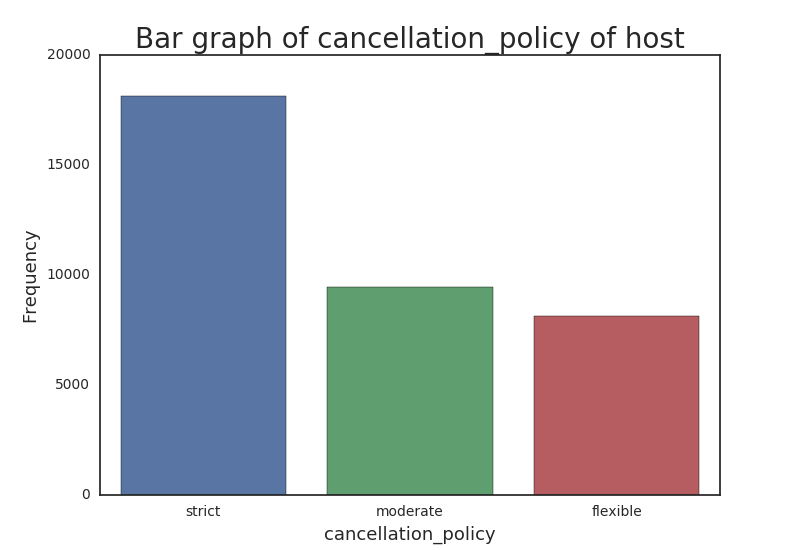

In [37]:

target_counts = pd.DataFrame({'cancellation_policy': list(value_counts.index), 'value_count': value_counts})
target_counts

sns.set(style="white")

plt.figure()
g = sns.barplot(x='cancellation_policy', y='value_count', data=target_counts, capsize=0.8)
g.set_title("Bar graph of cancellation_policy of host", fontsize=20)
g.set_xlabel("cancellation_policy", fontsize=13)
g.set_ylabel("Frequency", fontsize=13)
g.set_yticks([0, 5000, 10000, 15000, 20000])
display(g.figure)



In [38]:

original_value_counts1 = pandas_df.property_type.value_counts()
print(original_value_counts1)

pandas_df['property_type'].replace('Townhouse','House',inplace=True)

def recode1(value):
    if value not in ['House', 'Apartment', 'Condominium']:
        return 'Other'
    return value

pandas_df['property_type'] = pandas_df['property_type'].apply(recode1)



value_counts1 = pandas_df.property_type.value_counts()
print(value_counts1)


Apartment 28372
House 2805
Townhouse 1360
Loft 1215
Condominium 926
Serviced apartment 388
Guest suite 230
Other 88
Bed and breakfast 67
Boutique hotel 65
Resort 51
Guesthouse 44
Hostel 41
Bungalow 23
Hotel 22
Villa 13
Tiny house 11
Aparthotel 7
Cottage 5
Boat 4
Camper/RV 3
Tent 3
Earth house 2
Cabin 1
Houseboat 1
Castle 1
Casa particular (Cuba) 1
Nature lodge 1
Cave 1
Name: property_type, dtype: int64
Apartment 28372
House 4165
Other 2288
Condominium 926
Name: property_type, dtype: int64

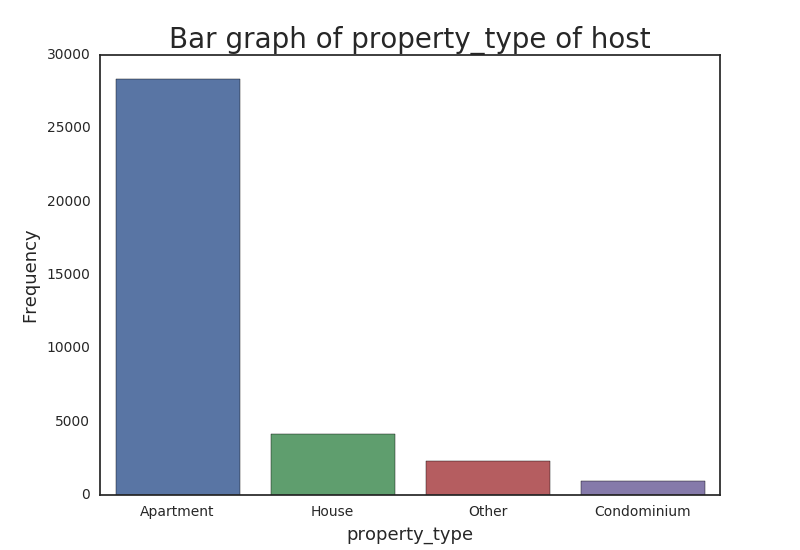

In [39]:

target_counts1 = pd.DataFrame({'property_type': list(value_counts1.index), 'value_count': value_counts1})
target_counts1


sns.set(style="white")

plt.figure()
g = sns.barplot(x='property_type', y='value_count', data=target_counts1, capsize=0.8)
g.set_title("Bar graph of property_type of host", fontsize=20)
g.set_xlabel("property_type", fontsize=13)
g.set_ylabel("Frequency", fontsize=13)
#g.set_yticks([0, 500, 1000, 1500, 2000])
display(g.figure)



In [40]:

original_value_counts2 = pandas_df.bed_type.value_counts()
print(original_value_counts2)

def recode3(value):
    if value not in ['Real Bed']:
        return 'Other'
    return value

pandas_df['bed_type'] = pandas_df['bed_type'].apply(recode3)



value_counts2 = pandas_df.bed_type.value_counts()
print(value_counts2)



Real Bed 35071
Futon 264
Pull-out Sofa 217
Airbed 141
Couch 58
Name: bed_type, dtype: int64
Real Bed 35071
Other 680
Name: bed_type, dtype: int64

In [41]:
pandas_df['bed_type'].replace('Real Bed',1, inplace=True)
pandas_df['bed_type'].replace('Other',0, inplace=True)

In [42]:
pandas_df.describe()

Out[ 179 ]: 
 id host_id host_is_superhost \
count 3.575100e+04 3.575100e+04 35751.000000 
mean 1.551948e+07 5.140906e+07 0.210232 
std 8.713890e+06 5.985232e+07 0.407479 
min 2.515000e+03 2.758000e+03 0.000000 
25% 7.901822e+06 6.656617e+06 0.000000 
50% 1.622958e+07 2.455918e+07 0.000000 
75% 2.246879e+07 7.536061e+07 0.000000 
max 3.047688e+07 2.285523e+08 1.000000 

 host_total_listings_count host_identity_verified is_location_exact \
count 35751.000000 35751.000000 35751.000000 
mean 3.637884 0.562865 0.844871 
std 10.229534 0.496039 0.362032 
min 1.000000 0.000000 0.000000 
25% 1.000000 0.000000 1.000000 
50% 1.000000 1.000000 1.000000 
75% 2.000000 1.000000 1.000000 
max 84.000000 1.000000 1.000000 

 accommodates bathrooms bedrooms beds bed_type \
count 35751.000000 35751.000000 35751.000000 35751.000000 35751.000000 
mean 2.937708 1.137227 1.180582 1.577159 0.980980 
std 1.779623 0.370796 0.719055 1.015005 0.136599 
min 1.000000 1.000000 0.000000 0.000000 0.000000 
25% 2.000000 1.000000 1.000000 1.000000 1.000000 
50% 2.000000 1.000000 1.000000 1.000000 1.000000 
75% 4.000000 1.000000 1.000000 2.000000 1.000000 
max 10.000000 3.000000 4.000000 6.000000 1.000000 

 price guests_included minimum_nights maximum_nights \
count 35751.000000 35751.000000 35751.000000 35751.000000 
mean 137.342648 1.571900 5.003049 592.670191 
std 104.152263 1.071734 7.573016 533.857361 
min 30.000000 1.000000 1.000000 3.000000 
25% 70.000000 1.000000 1.000000 29.000000 
50% 105.000000 1.000000 2.000000 500.000000 
75% 170.000000 2.000000 4.000000 1125.000000 
max 650.000000 6.000000 30.000000 1125.000000 

 review_scores_value requires_license instant_bookable \
count 35751.000000 35751.0 35751.000000 
mean 9.288887 0.0 0.361137 
std 1.189422 0.0 0.480337 
min 1.000000 0.0 0.000000 
25% 9.000000 0.0 0.000000 
50% 10.000000 0.0 0.000000 
75% 10.000000 0.0 1.000000 
max 10.000000 0.0 1.000000 

 is_business_travel_ready require_guest_phone_verification 
count 35751.0 35751.000000 
mean 0.0 0.027747 
std 0.0 0.164251 
min 0.0 0.000000 
25% 0.0 0.000000 
50% 0.0 0.000000 
75% 0.0 0.000000 
max 0.0 1.000000

In [43]:
#removing two columns
pandas_df =pandas_df.drop(['requires_license', 'is_business_travel_ready'], axis =1)


In [44]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35751 entries, 0 to 49103
Data columns (total 23 columns):
id 35751 non-null float64
summary 35751 non-null object
host_id 35751 non-null int64
host_is_superhost 35751 non-null int64
host_total_listings_count 35751 non-null int64
host_identity_verified 35751 non-null int64
zipcode 35751 non-null object
is_location_exact 35751 non-null int64
property_type 35751 non-null object
room_type 35751 non-null object
accommodates 35751 non-null float64
bathrooms 35751 non-null float64
bedrooms 35751 non-null float64
beds 35751 non-null int64
bed_type 35751 non-null int64
price 35751 non-null float64
guests_included 35751 non-null float64
minimum_nights 35751 non-null float64
maximum_nights 35751 non-null float64
review_scores_value 35751 non-null int64
instant_bookable 35751 non-null int64
cancellation_policy 35751 non-null object
require_guest_phone_verification 35751 non-null int64
dtypes: float64(8), int64(10), object(5)
memory usage: 6.5+ MB

## Descriptive Statistics

In [46]:
pandas_df.describe()

Out[ 182 ]: 
 id host_id host_is_superhost \
count 3.575100e+04 3.575100e+04 35751.000000 
mean 1.551948e+07 5.140906e+07 0.210232 
std 8.713890e+06 5.985232e+07 0.407479 
min 2.515000e+03 2.758000e+03 0.000000 
25% 7.901822e+06 6.656617e+06 0.000000 
50% 1.622958e+07 2.455918e+07 0.000000 
75% 2.246879e+07 7.536061e+07 0.000000 
max 3.047688e+07 2.285523e+08 1.000000 

 host_total_listings_count host_identity_verified is_location_exact \
count 35751.000000 35751.000000 35751.000000 
mean 3.637884 0.562865 0.844871 
std 10.229534 0.496039 0.362032 
min 1.000000 0.000000 0.000000 
25% 1.000000 0.000000 1.000000 
50% 1.000000 1.000000 1.000000 
75% 2.000000 1.000000 1.000000 
max 84.000000 1.000000 1.000000 

 accommodates bathrooms bedrooms beds bed_type \
count 35751.000000 35751.000000 35751.000000 35751.000000 35751.000000 
mean 2.937708 1.137227 1.180582 1.577159 0.980980 
std 1.779623 0.370796 0.719055 1.015005 0.136599 
min 1.000000 1.000000 0.000000 0.000000 0.000000 
25% 2.000000 1.000000 1.000000 1.000000 1.000000 
50% 2.000000 1.000000 1.000000 1.000000 1.000000 
75% 4.000000 1.000000 1.000000 2.000000 1.000000 
max 10.000000 3.000000 4.000000 6.000000 1.000000 

 price guests_included minimum_nights maximum_nights \
count 35751.000000 35751.000000 35751.000000 35751.000000 
mean 137.342648 1.571900 5.003049 592.670191 
std 104.152263 1.071734 7.573016 533.857361 
min 30.000000 1.000000 1.000000 3.000000 
25% 70.000000 1.000000 1.000000 29.000000 
50% 105.000000 1.000000 2.000000 500.000000 
75% 170.000000 2.000000 4.000000 1125.000000 
max 650.000000 6.000000 30.000000 1125.000000 

 review_scores_value instant_bookable require_guest_phone_verification 
count 35751.000000 35751.000000 35751.000000 
mean 9.288887 0.361137 0.027747 
std 1.189422 0.480337 0.164251 
min 1.000000 0.000000 0.000000 
25% 9.000000 0.000000 0.000000 
50% 10.000000 0.000000 0.000000 
75% 10.000000 1.000000 0.000000 
max 10.000000 1.000000 1.000000

## Descriptive analysis - Visualization

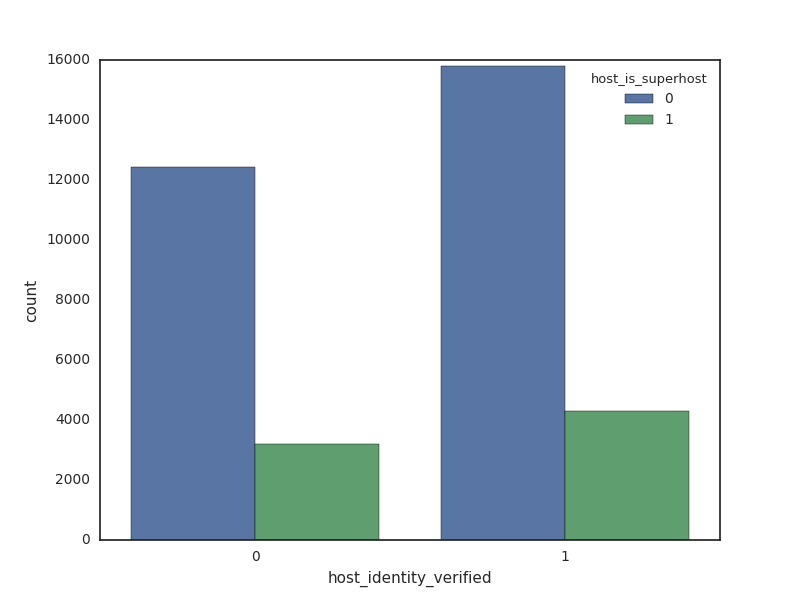

In [48]:
#visualization

f, ax = plt.subplots(figsize=(8, 6))
host=sns.countplot(x="host_identity_verified", hue = "host_is_superhost", data=pandas_df, ax=ax) 
display()

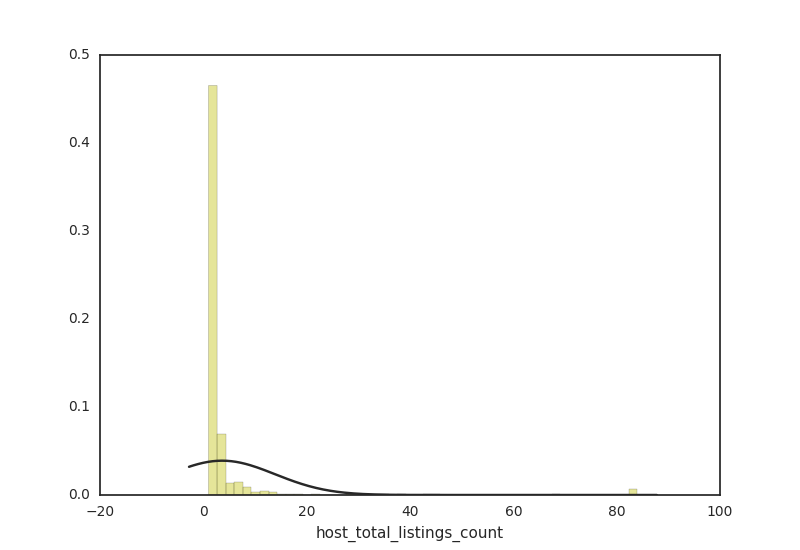

In [49]:
plt.figure()
g = sns.distplot(pandas_df['host_total_listings_count'],color='y',kde=False,fit=norm)
display()

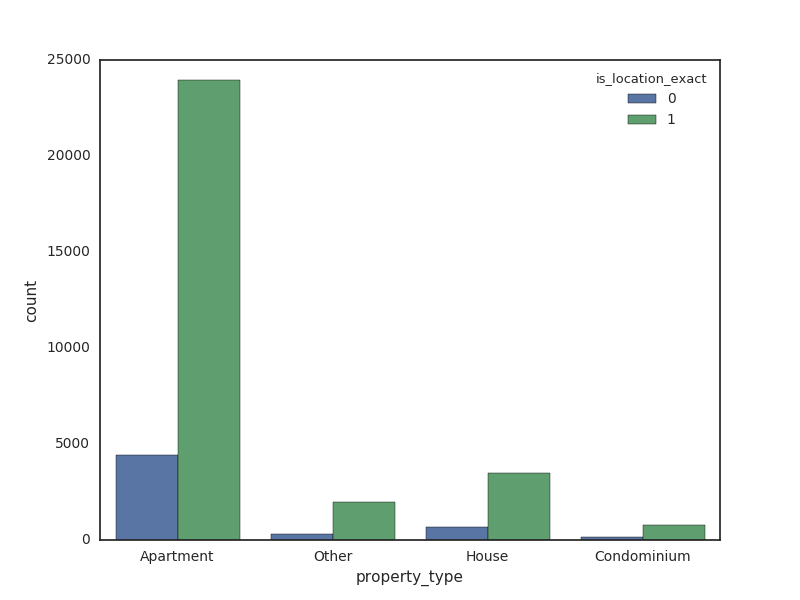

In [50]:
f,ax=plt.subplots(figsize=(8,6))
host=sns.countplot(x='property_type',hue='is_location_exact',data=pandas_df,ax=ax)
display()

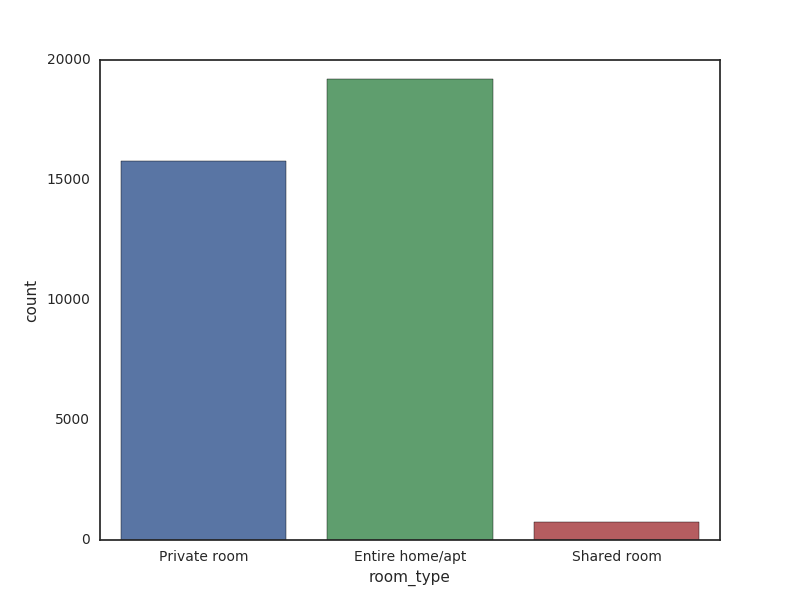

In [51]:
f,ax=plt.subplots(figsize=(8,6))
host=sns.countplot(x='room_type',data=pandas_df,ax=ax)
display()

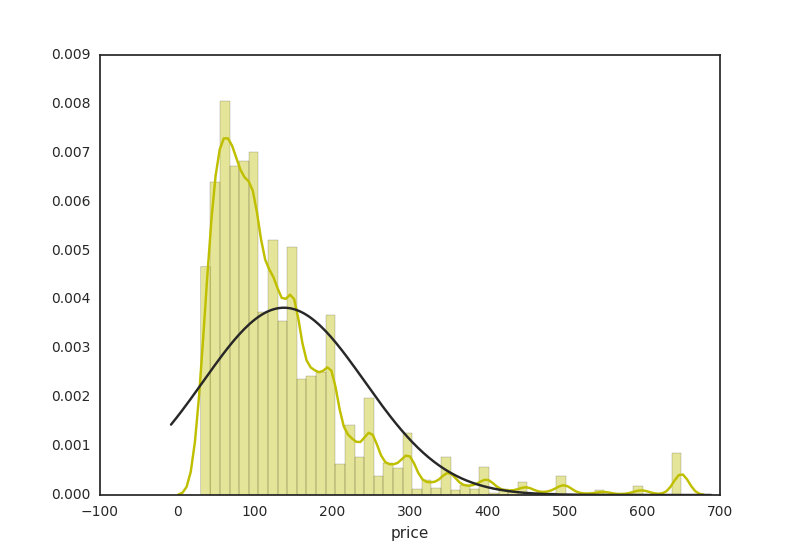

In [52]:
plt.figure()
g = sns.distplot(pandas_df['price'],color='y',fit=norm)
display()

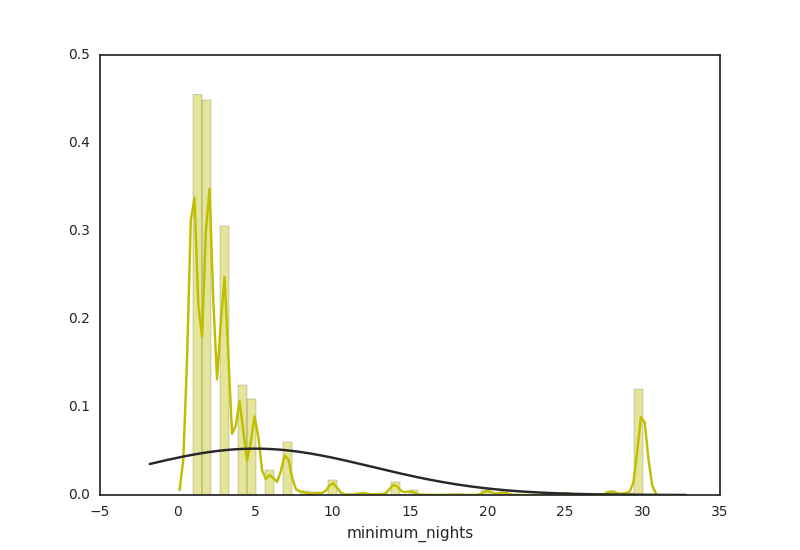

In [53]:
plt.figure()
g = sns.distplot(pandas_df['minimum_nights'],color='y',fit=norm)
display()

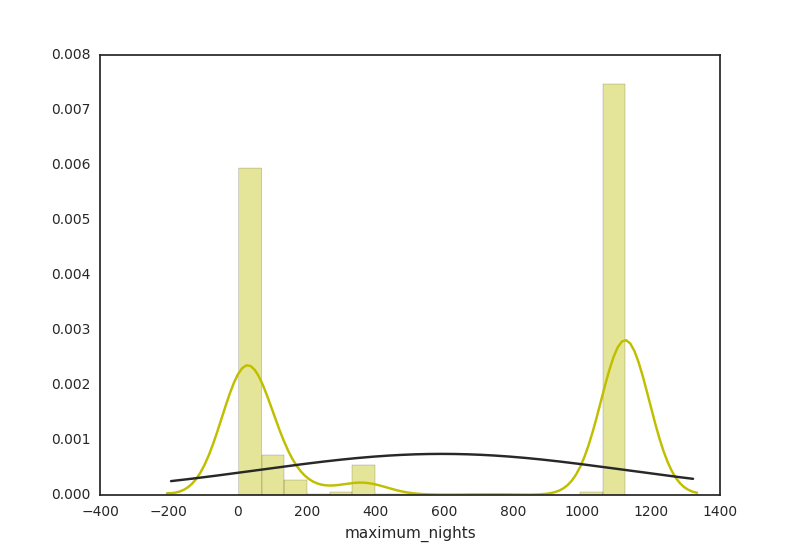

In [54]:
plt.figure()
g = sns.distplot(pandas_df['maximum_nights'],color='y',fit=norm)
display()

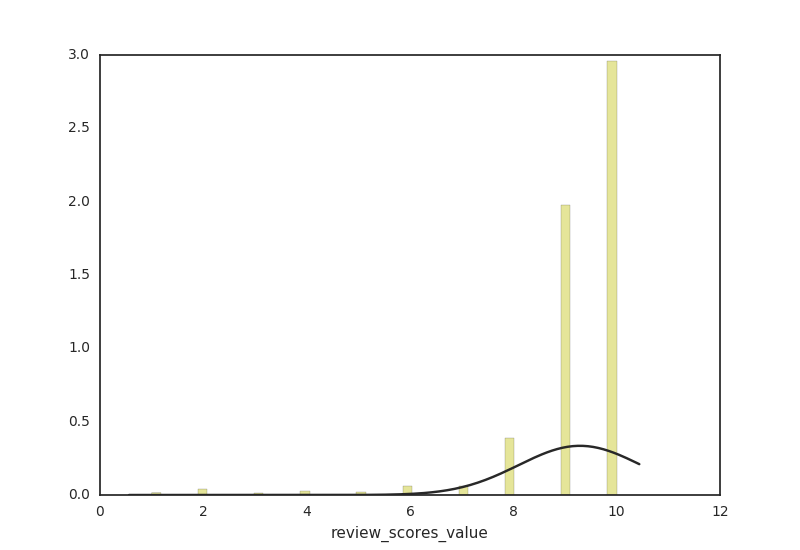

In [55]:
plt.figure()
g = sns.distplot(pandas_df['review_scores_value'],color='y',fit=norm,kde=False)
display()

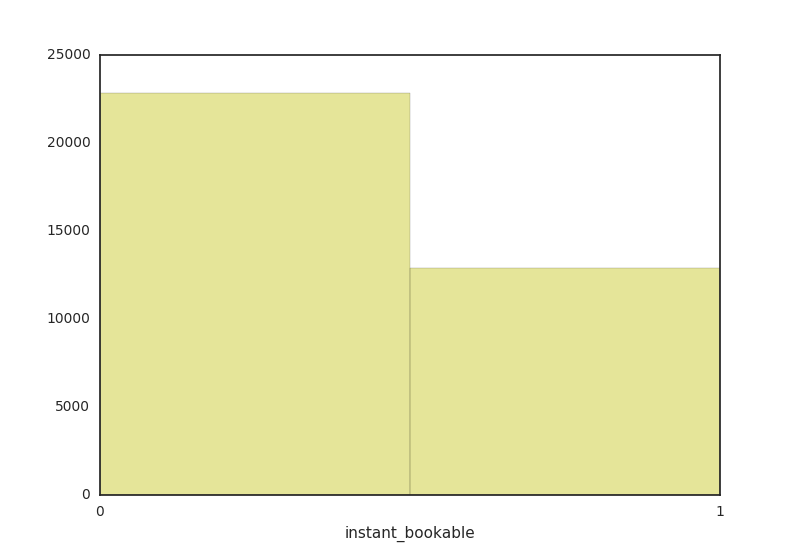

In [56]:
plt.figure()
sns.distplot(pandas_df['instant_bookable'],color='y',kde=False, bins=2)
plt.xticks([0,1])
display()

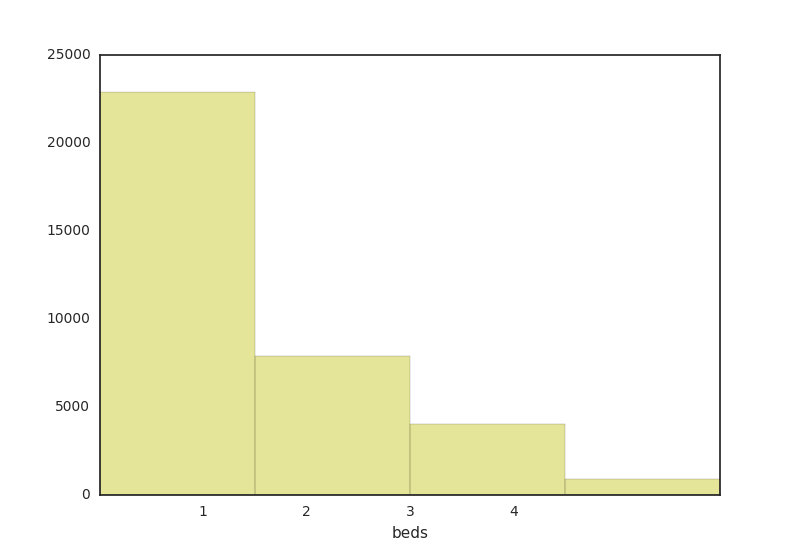

In [57]:
plt.figure()
sns.distplot(pandas_df['beds'],color='y',kde=False,bins=4)
plt.xticks([1,2,3,4])
display()

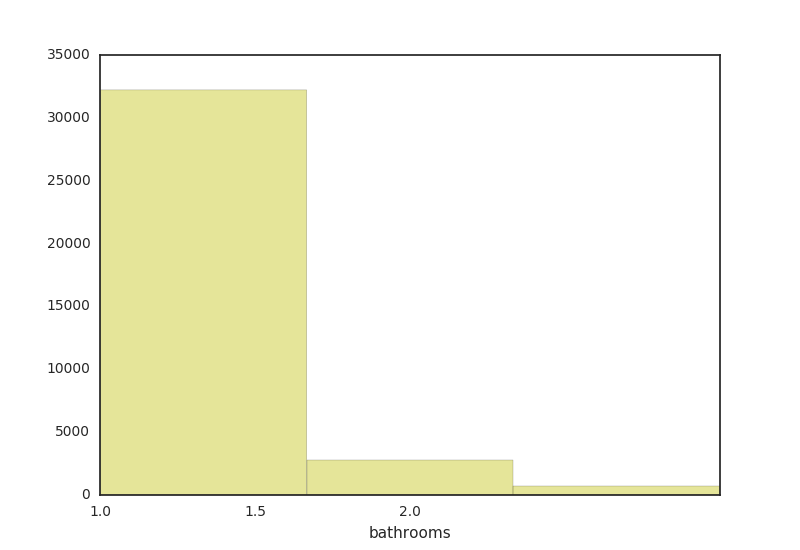

In [58]:
plt.figure()
sns.distplot(pandas_df['bathrooms'],color='y',kde=False,bins=3)
plt.xticks([1,1.5,2])
display()

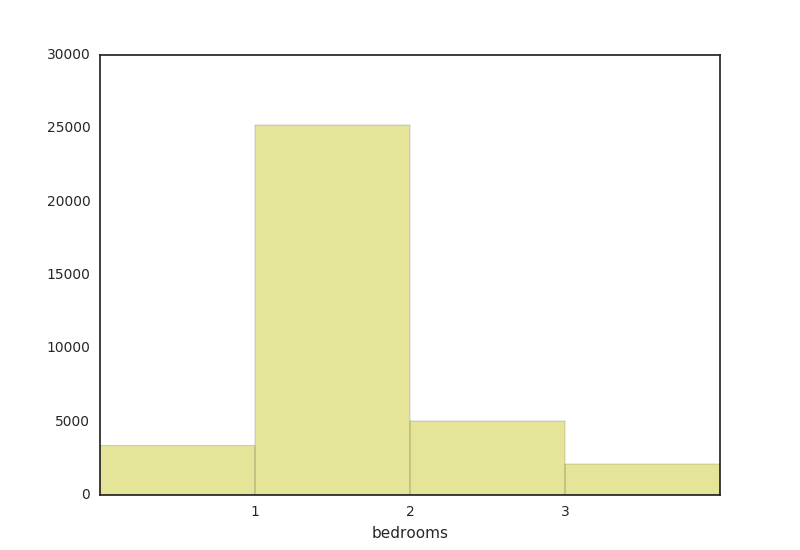

In [59]:
plt.figure()
sns.distplot(pandas_df['bedrooms'],color='y',kde=False,bins=4)
plt.xticks([1,2,3])
display()

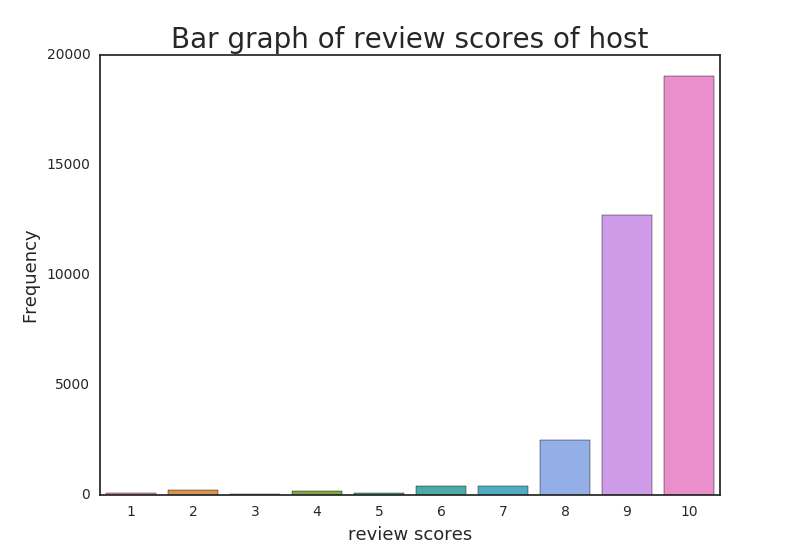

In [60]:

value_counts = pandas_df.review_scores_value.value_counts()
print(value_counts)
target_counts = pd.DataFrame({'review_scores_value': list(value_counts.index), 'value_count': value_counts})
target_counts
plt.figure()
g = sns.barplot(x='review_scores_value', y='value_count', data=target_counts, capsize=0.8)
g.set_title("Bar graph of review scores of host", fontsize=20)
g.set_xlabel("review scores", fontsize=13)
g.set_ylabel("Frequency", fontsize=13)
g.set_yticks([0, 5000, 10000, 15000, 20000])
display(g.figure)

## Create the dummy variables

In [62]:
#later visualization we can make dummy columns
pandas_df= pd.get_dummies(pandas_df, columns=['property_type', 'room_type', 'cancellation_policy'])

## Bucketize

In [64]:
price_bins = [0,50,100,150,200,250,300,650]
price_labels = [50,100,150,200,250,300,650]
pandas_df['price1'] = pd.cut(pandas_df['price'], bins=price_bins, labels=price_labels,include_lowest=True)

min_bins = [0,1,3,20,30]
min_labels = [1,3,20,30]
pandas_df['minimum_nights1'] = pd.cut(pandas_df['minimum_nights'], bins=min_bins, labels=min_labels,include_lowest=True)

max_bins = [0,100,1150,1200]
max_labels = [100,1150,1200]

pandas_df['host_total_listings_count1'] = pd.qcut(pandas_df['host_total_listings_count'].rank(method='first'), 4, labels=False)

In [65]:
pandas_df['price1'].value_counts().sum()

Out[ 198 ]: 35751

In [66]:
pandas_df['minimum_nights1'].value_counts()

Out[ 199 ]: 
3 15636
1 9437
20 7867
30 2811
Name: minimum_nights1, dtype: int64

In [67]:
pandas_df['host_total_listings_count1'].value_counts()

Out[ 200 ]: 
3 8938
1 8938
0 8938
2 8937
Name: host_total_listings_count1, dtype: int64

In [68]:
pandas_df['price1'] = pandas_df['price1'].astype('float64')
pandas_df['minimum_nights1'] = pandas_df['minimum_nights1'].astype('float64')
pandas_df['host_total_listings_count1'] = pandas_df['host_total_listings_count1'].astype('float64')

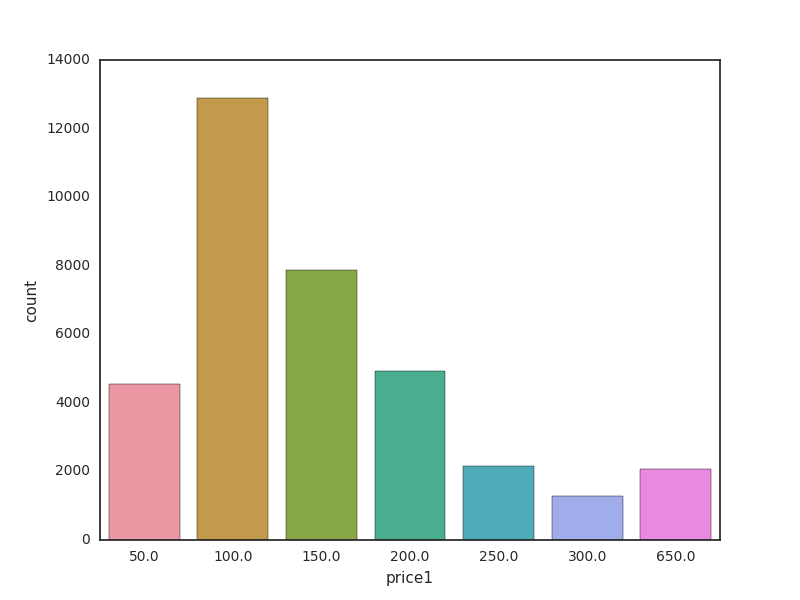

In [69]:
f,ax=plt.subplots(figsize=(8,6))
host=sns.countplot(x='price1',data=pandas_df,ax=ax)
display()

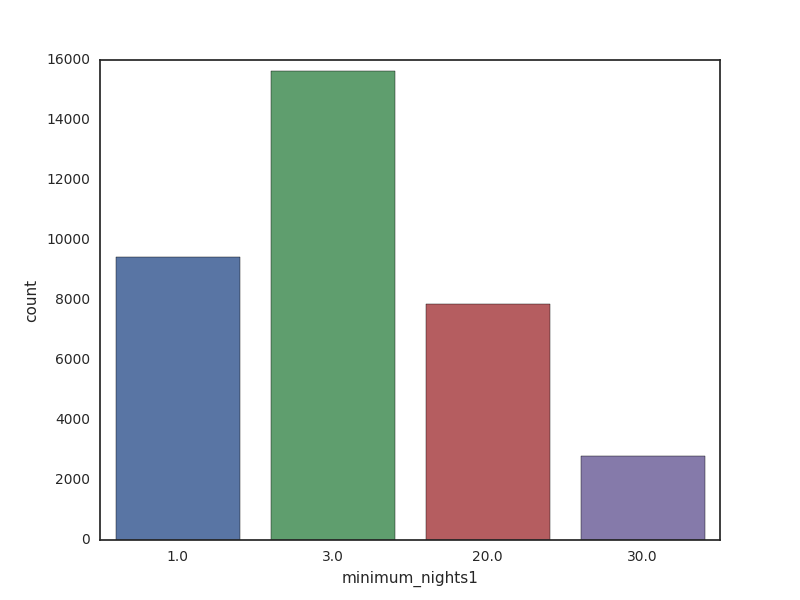

In [70]:

f,ax=plt.subplots(figsize=(8,6))
host=sns.countplot(x='minimum_nights1',data=pandas_df,ax=ax)
display()

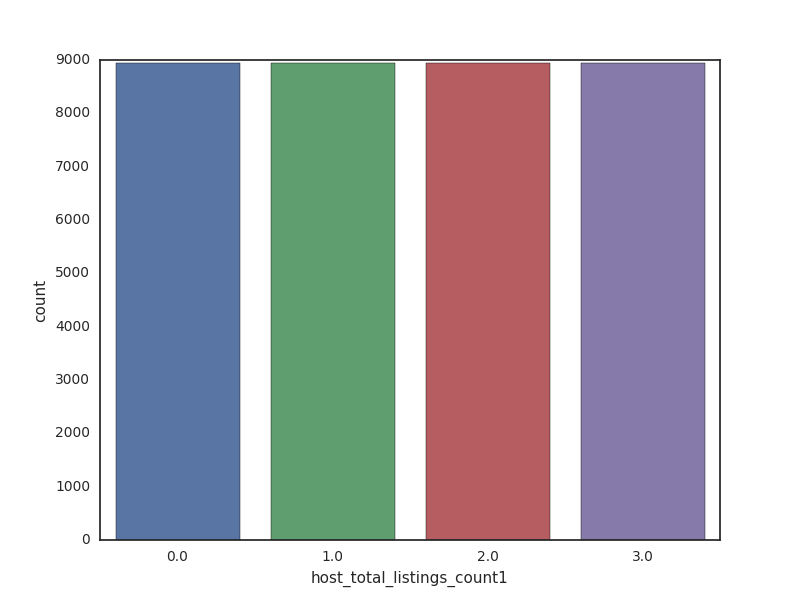

In [71]:

f,ax=plt.subplots(figsize=(8,6))
host=sns.countplot(x='host_total_listings_count1',data=pandas_df,ax=ax)
display()


In [72]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35751 entries, 0 to 49103
Data columns (total 33 columns):
id 35751 non-null float64
summary 35751 non-null object
host_id 35751 non-null int64
host_is_superhost 35751 non-null int64
host_total_listings_count 35751 non-null int64
host_identity_verified 35751 non-null int64
zipcode 35751 non-null object
is_location_exact 35751 non-null int64
accommodates 35751 non-null float64
bathrooms 35751 non-null float64
bedrooms 35751 non-null float64
beds 35751 non-null int64
bed_type 35751 non-null int64
price 35751 non-null float64
guests_included 35751 non-null float64
minimum_nights 35751 non-null float64
maximum_nights 35751 non-null float64
review_scores_value 35751 non-null int64
instant_bookable 35751 non-null int64
require_guest_phone_verification 35751 non-null int64
property_type_Apartment 35751 non-null uint8
property_type_Condominium 35751 non-null uint8
property_type_House 35751 non-null uint8
property_type_Other 35751 non-null uint8
room_type_Entire home/apt 35751 non-null uint8
room_type_Private room 35751 non-null uint8
room_type_Shared room 35751 non-null uint8
cancellation_policy_flexible 35751 non-null uint8
cancellation_policy_moderate 35751 non-null uint8
cancellation_policy_strict 35751 non-null uint8
price1 35751 non-null float64
minimum_nights1 35751 non-null float64
host_total_listings_count1 35751 non-null float64
dtypes: float64(11), int64(10), object(2), uint8(10)
memory usage: 6.9+ MB

In [73]:
pandas_df['price']=pandas_df['price1']
pandas_df['minimum_nights']=pandas_df['minimum_nights1']
pandas_df['host_total_listings_count']=pandas_df['host_total_listings_count1']
pandas_df =pandas_df.drop(['minimum_nights1', 'price1','host_total_listings_count1'], axis =1)


In [74]:

pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35751 entries, 0 to 49103
Data columns (total 30 columns):
id 35751 non-null float64
summary 35751 non-null object
host_id 35751 non-null int64
host_is_superhost 35751 non-null int64
host_total_listings_count 35751 non-null float64
host_identity_verified 35751 non-null int64
zipcode 35751 non-null object
is_location_exact 35751 non-null int64
accommodates 35751 non-null float64
bathrooms 35751 non-null float64
bedrooms 35751 non-null float64
beds 35751 non-null int64
bed_type 35751 non-null int64
price 35751 non-null float64
guests_included 35751 non-null float64
minimum_nights 35751 non-null float64
maximum_nights 35751 non-null float64
review_scores_value 35751 non-null int64
instant_bookable 35751 non-null int64
require_guest_phone_verification 35751 non-null int64
property_type_Apartment 35751 non-null uint8
property_type_Condominium 35751 non-null uint8
property_type_House 35751 non-null uint8
property_type_Other 35751 non-null uint8
room_type_Entire home/apt 35751 non-null uint8
room_type_Private room 35751 non-null uint8
room_type_Shared room 35751 non-null uint8
cancellation_policy_flexible 35751 non-null uint8
cancellation_policy_moderate 35751 non-null uint8
cancellation_policy_strict 35751 non-null uint8
dtypes: float64(9), int64(9), object(2), uint8(10)
memory usage: 6.1+ MB

## Model Building

In [76]:
pandas_df.describe()

Out[ 208 ]: 
 id host_id host_is_superhost \
count 3.575100e+04 3.575100e+04 35751.000000 
mean 1.551948e+07 5.140906e+07 0.210232 
std 8.713890e+06 5.985232e+07 0.407479 
min 2.515000e+03 2.758000e+03 0.000000 
25% 7.901822e+06 6.656617e+06 0.000000 
50% 1.622958e+07 2.455918e+07 0.000000 
75% 2.246879e+07 7.536061e+07 0.000000 
max 3.047688e+07 2.285523e+08 1.000000 

 host_total_listings_count host_identity_verified is_location_exact \
count 35751.000000 35751.000000 35751.000000 
mean 1.499986 0.562865 0.844871 
std 1.118062 0.496039 0.362032 
min 0.000000 0.000000 0.000000 
25% 0.500000 0.000000 1.000000 
50% 1.000000 1.000000 1.000000 
75% 2.500000 1.000000 1.000000 
max 3.000000 1.000000 1.000000 

 accommodates bathrooms bedrooms beds \
count 35751.000000 35751.000000 35751.000000 35751.000000 
mean 2.937708 1.137227 1.180582 1.577159 
std 1.779623 0.370796 0.719055 1.015005 
min 1.000000 1.000000 0.000000 0.000000 
25% 2.000000 1.000000 1.000000 1.000000 
50% 2.000000 1.000000 1.000000 1.000000 
75% 4.000000 1.000000 1.000000 2.000000 
max 10.000000 3.000000 4.000000 6.000000 

 ... property_type_Apartment \
count ... 35751.000000 
mean ... 0.793600 
std ... 0.404726 
min ... 0.000000 
25% ... 1.000000 
50% ... 1.000000 
75% ... 1.000000 
max ... 1.000000 

 property_type_Condominium property_type_House property_type_Other \
count 35751.000000 35751.000000 35751.000000 
mean 0.025901 0.116500 0.063998 
std 0.158843 0.320828 0.244753 
min 0.000000 0.000000 0.000000 
25% 0.000000 0.000000 0.000000 
50% 0.000000 0.000000 0.000000 
75% 0.000000 0.000000 0.000000 
max 1.000000 1.000000 1.000000 

 room_type_Entire home/apt room_type_Private room \
count 35751.000000 35751.000000 
mean 0.537076 0.442253 
std 0.498630 0.496661 
min 0.000000 0.000000 
25% 0.000000 0.000000 
50% 1.000000 0.000000 
75% 1.000000 1.000000 
max 1.000000 1.000000 

 room_type_Shared room cancellation_policy_flexible \
count 35751.000000 35751.000000 
mean 0.020671 0.227938 
std 0.142282 0.419508 
min 0.000000 0.000000 
25% 0.000000 0.000000 
50% 0.000000 0.000000 
75% 0.000000 0.000000 
max 1.000000 1.000000 

 cancellation_policy_moderate cancellation_policy_strict 
count 35751.000000 35751.000000 
mean 0.264300 0.507762 
std 0.440966 0.499947 
min 0.000000 0.000000 
25% 0.000000 0.000000 
50% 0.000000 1.000000 
75% 1.000000 1.000000 
max 1.000000 1.000000 

[8 rows x 28 columns]

In [77]:
model_df =pandas_df.drop(['id', 'host_id','summary','zipcode'], axis =1)
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35751 entries, 0 to 49103
Data columns (total 26 columns):
host_is_superhost 35751 non-null int64
host_total_listings_count 35751 non-null float64
host_identity_verified 35751 non-null int64
is_location_exact 35751 non-null int64
accommodates 35751 non-null float64
bathrooms 35751 non-null float64
bedrooms 35751 non-null float64
beds 35751 non-null int64
bed_type 35751 non-null int64
price 35751 non-null float64
guests_included 35751 non-null float64
minimum_nights 35751 non-null float64
maximum_nights 35751 non-null float64
review_scores_value 35751 non-null int64
instant_bookable 35751 non-null int64
require_guest_phone_verification 35751 non-null int64
property_type_Apartment 35751 non-null uint8
property_type_Condominium 35751 non-null uint8
property_type_House 35751 non-null uint8
property_type_Other 35751 non-null uint8
room_type_Entire home/apt 35751 non-null uint8
room_type_Private room 35751 non-null uint8
room_type_Shared room 35751 non-null uint8
cancellation_policy_flexible 35751 non-null uint8
cancellation_policy_moderate 35751 non-null uint8
cancellation_policy_strict 35751 non-null uint8
dtypes: float64(8), int64(8), uint8(10)
memory usage: 5.0 MB

In [78]:
#Correlation Matrix
fig, ax = plt.subplots(figsize=(16,10))
corr = pandas_df.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, linewidths=.5, ax=ax)
corr['review_scores_value'].sort_values(ascending=False)


Out[ 210 ]: 
review_scores_value 1.000000
id 0.173606
host_is_superhost 0.110218
cancellation_policy_flexible 0.053024
cancellation_policy_moderate 0.049135
host_id 0.038006
property_type_Condominium 0.020208
room_type_Private room 0.019338
bed_type 0.016088
property_type_House 0.012959
instant_bookable 0.000547
host_identity_verified -0.001388
room_type_Shared room -0.004047
maximum_nights -0.007834
property_type_Apartment -0.010302
bathrooms -0.011751
property_type_Other -0.013065
bedrooms -0.014458
room_type_Entire home/apt -0.018107
is_location_exact -0.025128
guests_included -0.026784
price -0.034671
beds -0.035146
accommodates -0.038292
host_total_listings_count -0.043159
minimum_nights -0.086039
cancellation_policy_strict -0.087831
require_guest_phone_verification -0.130662
Name: review_scores_value, dtype: float64

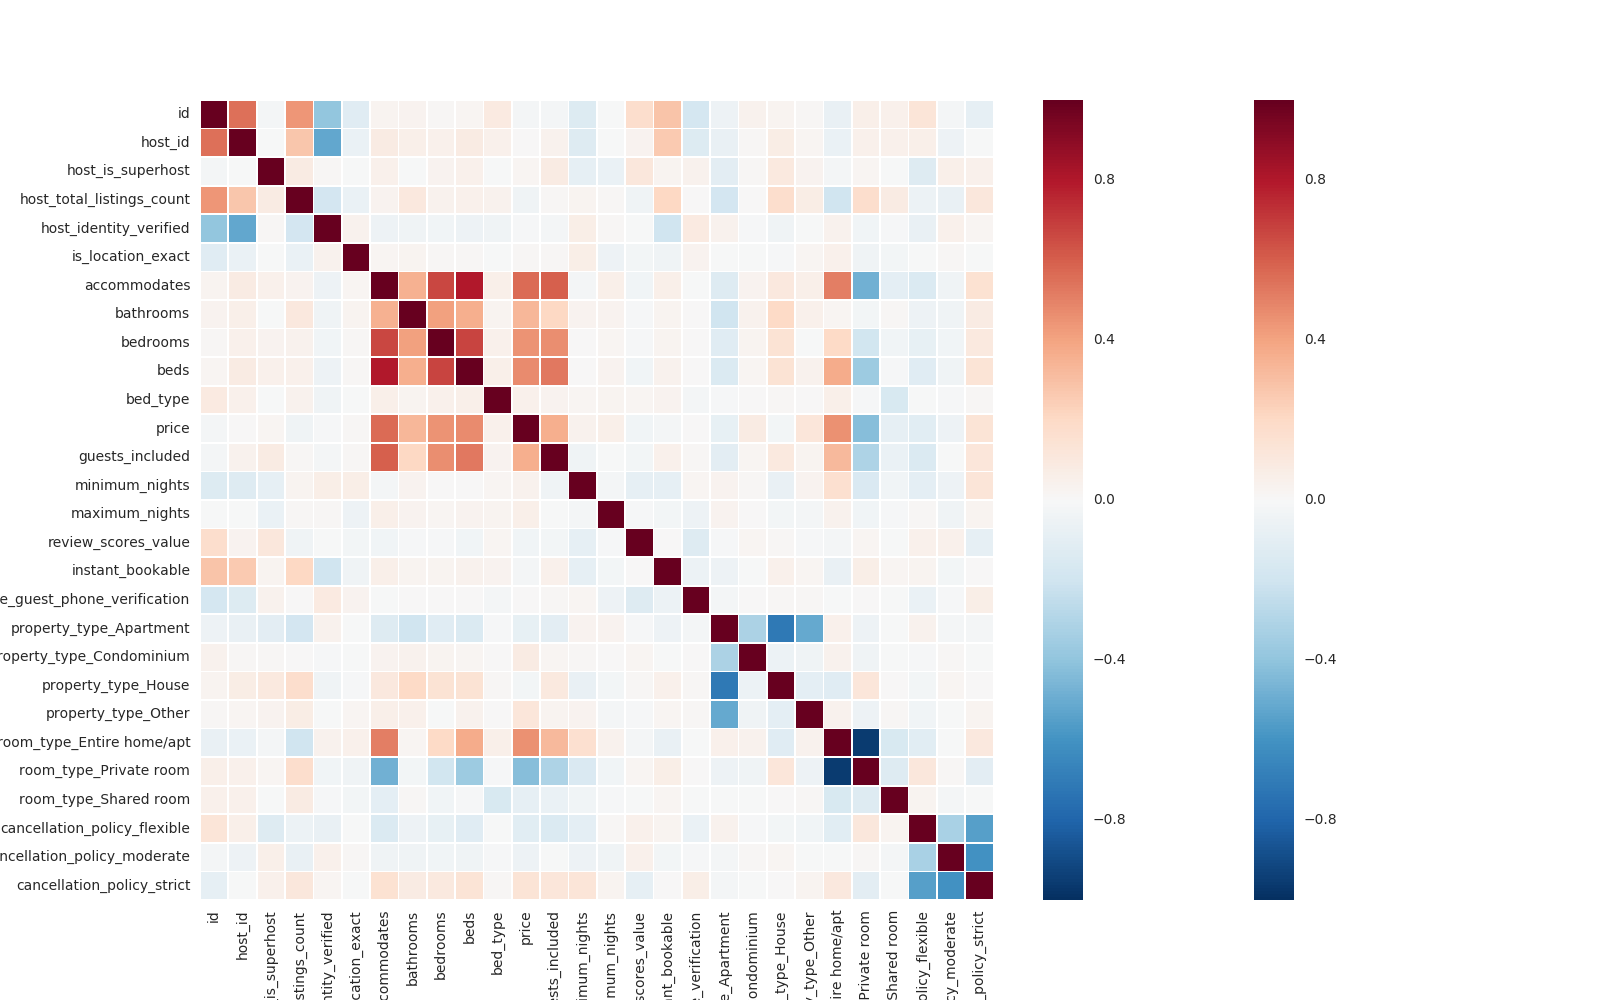

In [79]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, linewidths=.5, ax=ax)
corr['review_scores_value'].sort_values(ascending=False)
display()

## Start a modeling

## Convert Pandas df to Spark df

In [82]:
spark_df = sqlContext.createDataFrame(model_df)


In [83]:
spark_df.printSchema()

root
-- host_is_superhost: long (nullable = true)
-- host_total_listings_count: double (nullable = true)
-- host_identity_verified: long (nullable = true)
-- is_location_exact: long (nullable = true)
-- accommodates: double (nullable = true)
-- bathrooms: double (nullable = true)
-- bedrooms: double (nullable = true)
-- beds: long (nullable = true)
-- bed_type: long (nullable = true)
-- price: double (nullable = true)
-- guests_included: double (nullable = true)
-- minimum_nights: double (nullable = true)
-- maximum_nights: double (nullable = true)
-- review_scores_value: long (nullable = true)
-- instant_bookable: long (nullable = true)
-- require_guest_phone_verification: long (nullable = true)
-- property_type_Apartment: long (nullable = true)
-- property_type_Condominium: long (nullable = true)
-- property_type_House: long (nullable = true)
-- property_type_Other: long (nullable = true)
-- room_type_Entire home/apt: long (nullable = true)
-- room_type_Private room: long (nullable = true)
-- room_type_Shared room: long (nullable = true)
-- cancellation_policy_flexible: long (nullable = true)
-- cancellation_policy_moderate: long (nullable = true)
-- cancellation_policy_strict: long (nullable = true)

In [84]:
training_df, validation_df, testing_df = spark_df.randomSplit([0.6, 0.3, 0.1], )

In [85]:
[training_df.count(), validation_df.count(), testing_df.count()]

Out[ 215 ]: [21502, 10672, 3577]

In [86]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

## Start Build Pipeline

In [88]:
va = VectorAssembler().setInputCols(['host_is_superhost',
 'host_total_listings_count',
 'host_identity_verified',
 'is_location_exact',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'price',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'instant_bookable',
 'require_guest_phone_verification',
 'property_type_Apartment',
 'property_type_Condominium',
 'property_type_House',
 'property_type_Other',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'room_type_Shared room',
 'cancellation_policy_flexible',
 'cancellation_policy_moderate',
 'cancellation_policy_strict']).setOutputCol('features')

## Build a Feature Importance Function

In [90]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

## MSE Function

In [92]:
mse = fn.mean((fn.col('review_scores_value') - fn.col('prediction'))**2).alias('mse')

## Linear Regression

In [94]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol='review_scores_value')   # maxIter=10, regParam=0.02, elasticNetParam=0.3

In [95]:
# Build linear model
linear_pipe_model =Pipeline(stages = [va, lr]).fit(training_df)

In [96]:
linear_pipe_model_predictions = linear_pipe_model.transform(validation_df)

In [97]:
# Get coefficients
coeffs = linear_pipe_model.stages[1].coefficients.toArray().tolist()

feature_names = list(['host_is_superhost',
 'host_total_listings_count',
 'host_identity_verified',
 'is_location_exact',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'price',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'instant_bookable',
 'require_guest_phone_verification',
 'property_type_Apartment',
 'property_type_Condominium',
 'property_type_House',
 'property_type_Other',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'room_type_Shared room',
 'cancellation_policy_flexible',
 'cancellation_policy_moderate',
 'cancellation_policy_strict'])

coeff_df = pd.DataFrame([feature_names, coeffs]).T.rename(columns={0: 'Features', 
                                                                  1: 'Coefficients'})
coeff_df['ABS(Coefficients)'] = coeff_df.Coefficients.abs()
coeff_df = coeff_df.sort_values('ABS(Coefficients)', ascending = False)
coeff_df



Out[ 223 ]: 
 Features Coefficients ABS(Coefficients)
14 require_guest_phone_verification -0.87785 0.87785
0 host_is_superhost 0.355463 0.355463
16 property_type_Condominium 0.124728 0.124728
8 bed_type 0.121528 0.121528
24 cancellation_policy_strict -0.0800561 0.0800561
22 cancellation_policy_flexible 0.0776516 0.0776516
3 is_location_exact -0.0692786 0.0692786
21 room_type_Shared room -0.0623204 0.0623204
6 bedrooms 0.0522585 0.0522585
1 host_total_listings_count -0.0470213 0.0470213
5 bathrooms 0.0424433 0.0424433
18 property_type_Other -0.0353702 0.0353702
17 property_type_House 0.0344694 0.0344694
19 room_type_Entire home/apt 0.0323235 0.0323235
23 cancellation_policy_moderate 0.0322084 0.0322084
4 accommodates -0.0309421 0.0309421
15 property_type_Apartment -0.0278378 0.0278378
20 room_type_Private room -0.0275774 0.0275774
10 guests_included -0.0270892 0.0270892
13 instant_bookable -0.0219559 0.0219559
2 host_identity_verified 0.0142125 0.0142125
7 beds -0.00883227 0.00883227
11 minimum_nights -0.00846947 0.00846947
9 price -0.000170801 0.000170801
12 maximum_nights -2.74691e-05 2.74691e-05

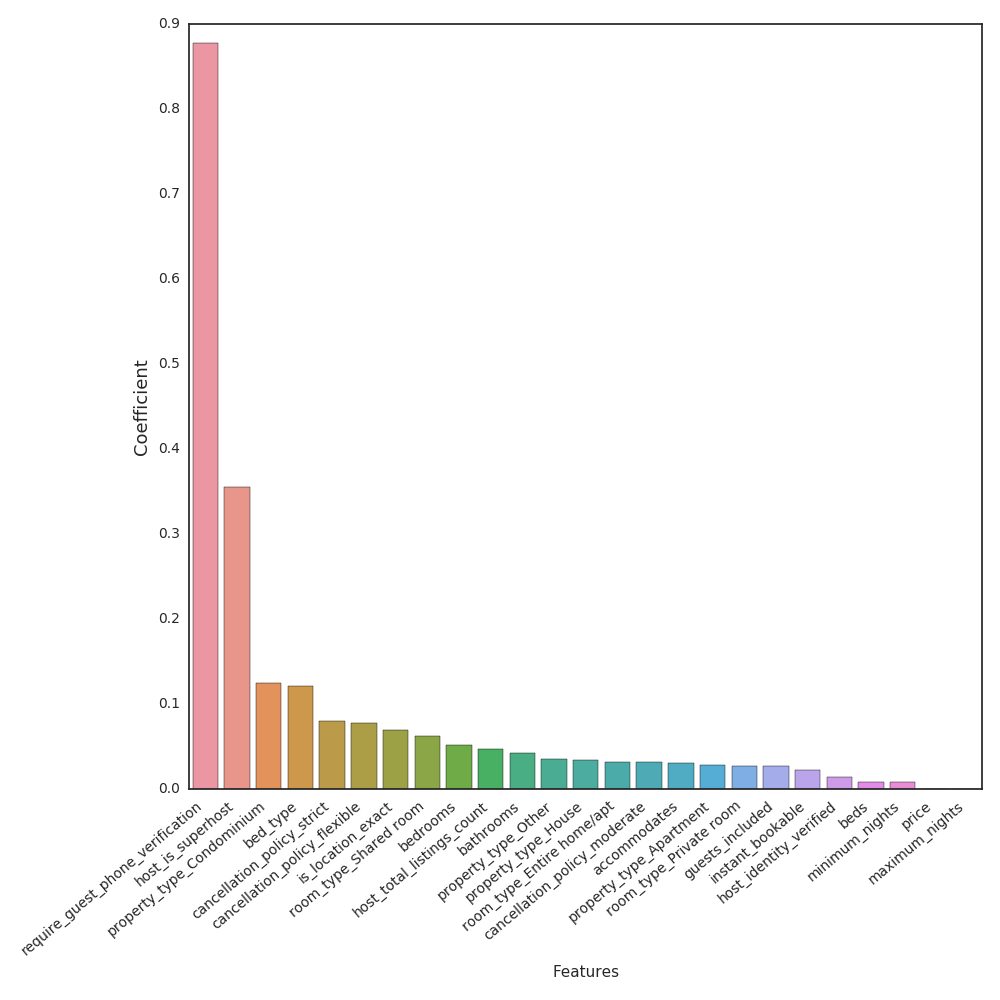

In [98]:
# Plot coefficients
plt.figure(figsize =(10,10))

coeff_plot = sns.barplot(x="Features", y="ABS(Coefficients)", data=coeff_df)
coeff_plot.set_xticklabels(coeff_plot.get_xticklabels(), rotation=40, ha="right")
coeff_plot.set_ylabel("Coefficient", fontsize=13)
plt.tight_layout()
display()

In [99]:
coeff_df

Out[ 225 ]: 
 Features Coefficients ABS(Coefficients)
14 require_guest_phone_verification -0.87785 0.87785
0 host_is_superhost 0.355463 0.355463
16 property_type_Condominium 0.124728 0.124728
8 bed_type 0.121528 0.121528
24 cancellation_policy_strict -0.0800561 0.0800561
22 cancellation_policy_flexible 0.0776516 0.0776516
3 is_location_exact -0.0692786 0.0692786
21 room_type_Shared room -0.0623204 0.0623204
6 bedrooms 0.0522585 0.0522585
1 host_total_listings_count -0.0470213 0.0470213
5 bathrooms 0.0424433 0.0424433
18 property_type_Other -0.0353702 0.0353702
17 property_type_House 0.0344694 0.0344694
19 room_type_Entire home/apt 0.0323235 0.0323235
23 cancellation_policy_moderate 0.0322084 0.0322084
4 accommodates -0.0309421 0.0309421
15 property_type_Apartment -0.0278378 0.0278378
20 room_type_Private room -0.0275774 0.0275774
10 guests_included -0.0270892 0.0270892
13 instant_bookable -0.0219559 0.0219559
2 host_identity_verified 0.0142125 0.0142125
7 beds -0.00883227 0.00883227
11 minimum_nights -0.00846947 0.00846947
9 price -0.000170801 0.000170801
12 maximum_nights -2.74691e-05 2.74691e-05

In [100]:
lr_va1 = VectorAssembler().setInputCols(['require_guest_phone_verification']).setOutputCol('features')
lr_va2 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost']).setOutputCol('features')
lr_va3 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium']).setOutputCol('features')
lr_va4 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type']).\
                        setOutputCol('features')
lr_va5 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room']).\
                        setOutputCol('features')
lr_va6 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict']).\
                        setOutputCol('features')
lr_va7 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible']).\
                        setOutputCol('features')
lr_va8 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible','is_location_exact']).\
                        setOutputCol('features')
lr_va9 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible','is_location_exact','bedrooms']).\
                        setOutputCol('features')
lr_va10 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible','is_location_exact','bedrooms','room_type_Entire home/apt']).\
                        setOutputCol('features')
lr_va11 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible','is_location_exact','bedrooms','room_type_Entire home/apt','room_type_Private room']).\
                        setOutputCol('features')
lr_va12 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible','is_location_exact','bedrooms','room_type_Entire home/apt','room_type_Private room','host_total_listings_count']).\
                        setOutputCol('features')
lr_va13 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible','is_location_exact','bedrooms','room_type_Entire home/apt','room_type_Private room','host_total_listings_count','cancellation_policy_moderate']).\
                        setOutputCol('features')
lr_va14 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible','is_location_exact','bedrooms','room_type_Entire home/apt','room_type_Private room','host_total_listings_count','cancellation_policy_moderate','bathrooms']).\
                        setOutputCol('features')
lr_va15 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible','is_location_exact','bedrooms','room_type_Entire home/apt','room_type_Private room','host_total_listings_count','cancellation_policy_moderate','bathrooms',
'guests_included']).\
                        setOutputCol('features')
lr_va16 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible','is_location_exact','bedrooms','room_type_Entire home/apt','room_type_Private room','host_total_listings_count','cancellation_policy_moderate','bathrooms',
'guests_included','property_type_Apartment']).\
                        setOutputCol('features')
lr_va17 = VectorAssembler().setInputCols(['require_guest_phone_verification', 'host_is_superhost', 'property_type_Condominium', 'bed_type','room_type_Shared room','cancellation_policy_strict',
'cancellation_policy_flexible','is_location_exact','bedrooms','room_type_Entire home/apt','room_type_Private room','host_total_listings_count','cancellation_policy_moderate','bathrooms',
'guests_included','property_type_Apartment']).\
                        setOutputCol('features')


In [101]:

lr_model_1 = Pipeline(stages = [lr_va1,lr]).fit(training_df)
lr_model_2 = Pipeline(stages = [lr_va2, lr]).fit(training_df)
lr_model_3 = Pipeline(stages = [lr_va3, lr]).fit(training_df)
lr_model_4 = Pipeline(stages = [lr_va4, lr]).fit(training_df)
lr_model_5 = Pipeline(stages = [lr_va5, lr]).fit(training_df)
lr_model_6 = Pipeline(stages = [lr_va6, lr]).fit(training_df)
lr_model_7 = Pipeline(stages = [lr_va7, lr]).fit(training_df)
lr_model_8 = Pipeline(stages = [lr_va8, lr]).fit(training_df)
lr_model_9 = Pipeline(stages = [lr_va9, lr]).fit(training_df)
lr_model_10 = Pipeline(stages = [lr_va10, lr]).fit(training_df)
lr_model_11 = Pipeline(stages = [lr_va11, lr]).fit(training_df)
lr_model_12 = Pipeline(stages = [lr_va12, lr]).fit(training_df)
lr_model_13 = Pipeline(stages = [lr_va13, lr]).fit(training_df)
lr_model_14 = Pipeline(stages = [lr_va14, lr]).fit(training_df)
lr_model_15 = Pipeline(stages = [lr_va15, lr]).fit(training_df)
lr_model_16 = Pipeline(stages = [lr_va16, lr]).fit(training_df)
lr_model_17 = Pipeline(stages = [lr_va17, lr]).fit(training_df)


In [102]:
lr_predictions1 = lr_model_1.transform(validation_df)
lr_predictions2 = lr_model_2.transform(validation_df)
lr_predictions3 = lr_model_3.transform(validation_df)
lr_predictions4 = lr_model_4.transform(validation_df)
lr_predictions5 = lr_model_5.transform(validation_df)
lr_predictions6 = lr_model_6.transform(validation_df)
lr_predictions7 = lr_model_7.transform(validation_df)
lr_predictions8 = lr_model_8.transform(validation_df)
lr_predictions9 = lr_model_9.transform(validation_df)
lr_predictions10 = lr_model_10.transform(validation_df)
lr_predictions11 = lr_model_11.transform(validation_df)
lr_predictions12 = lr_model_12.transform(validation_df)
lr_predictions13 = lr_model_13.transform(validation_df)
lr_predictions14 = lr_model_14.transform(validation_df)
lr_predictions15 = lr_model_15.transform(validation_df)
lr_predictions16 = lr_model_16.transform(validation_df)
lr_predictions17 = lr_model_17.transform(validation_df)


In [103]:
lr_mse1 = lr_model_1.transform(validation_df).select(mse)
lr_mse2 = lr_model_2.transform(validation_df).select(mse)
lr_mse3 = lr_model_3.transform(validation_df).select(mse)
lr_mse4 = lr_model_4.transform(validation_df).select(mse)
lr_mse5 = lr_model_5.transform(validation_df).select(mse)
lr_mse6 = lr_model_6.transform(validation_df).select(mse)
lr_mse7 = lr_model_7.transform(validation_df).select(mse)
lr_mse8 = lr_model_8.transform(validation_df).select(mse)
lr_mse9 = lr_model_9.transform(validation_df).select(mse)
lr_mse10 = lr_model_10.transform(validation_df).select(mse)
lr_mse11 = lr_model_11.transform(validation_df).select(mse)
lr_mse12 = lr_model_12.transform(validation_df).select(mse)
lr_mse13 = lr_model_13.transform(validation_df).select(mse)
lr_mse14 = lr_model_14.transform(validation_df).select(mse)
lr_mse15 = lr_model_15.transform(validation_df).select(mse)
lr_mse16 = lr_model_16.transform(validation_df).select(mse)
lr_mse17 = lr_model_17.transform(validation_df).select(mse)


In [104]:
lr_mse_plot = lr_mse1.union(lr_mse2).union(lr_mse3).union(lr_mse4).union(lr_mse5).union(lr_mse6).union(lr_mse7).union(lr_mse8).union(lr_mse9).union(lr_mse10).union(lr_mse11).union(lr_mse12).union(lr_mse13).union(lr_mse14).union(lr_mse15).union(lr_mse16).union(lr_mse17)

In [105]:
lr_mse_plot.toPandas()

Out[ 231 ]: 
 mse
0 1.442407
1 1.424496
2 1.423883
3 1.423570
4 1.423570
5 1.409840
6 1.409971
7 1.409567
8 1.409342
9 1.409572
10 1.409572
11 1.408493
12 1.408493
13 1.408481
14 1.409032
15 1.409262
16 1.409262

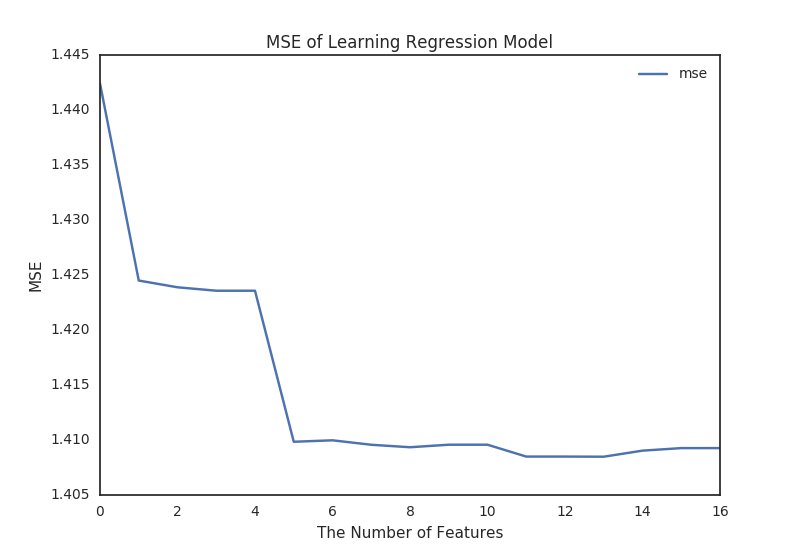

In [106]:
lr_mse_plot.toPandas().plot()
plt.xlabel('The Number of Features')
plt.ylabel('MSE')
plt.title('MSE of Linear Regression Model')
display()

In [107]:
linear_pipe_model.transform(validation_df).select(mse).show()

+------------------+
 mse|
+------------------+
1.4020526239322861|
+------------------+

## Decision Tree Regression

In [109]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol='review_scores_value')

In [110]:
dt_pipe_model = Pipeline(stages = [va, dt]).fit(training_df)

In [111]:
# Make predictions.
dt_pipe_model_predictions = dt_pipe_model.transform(validation_df)

In [112]:
dt_pipe_model.transform(validation_df).select(mse).show()

+-----------------+
 mse|
+-----------------+
1.403958356739834|
+-----------------+

In [113]:
dt_feature_df = ExtractFeatureImp(dt_pipe_model.stages[-1].featureImportances, dt_pipe_model_predictions, "features")
dt_feature_df

Out[ 238 ]: 
 idx name score
1 1 host_total_listings_count 0.201473
11 11 minimum_nights 0.201209
14 14 require_guest_phone_verification 0.186825
0 0 host_is_superhost 0.155126
10 10 guests_included 0.059711
6 6 bedrooms 0.054775
15 15 property_type_Apartment 0.040374
9 9 price 0.032741
4 4 accommodates 0.016032
23 23 cancellation_policy_moderate 0.013808
12 12 maximum_nights 0.013382
24 24 cancellation_policy_strict 0.010722
7 7 beds 0.009478
17 17 property_type_House 0.003456
16 16 property_type_Condominium 0.000888
8 8 bed_type 0.000000
13 13 instant_bookable 0.000000
5 5 bathrooms 0.000000
3 3 is_location_exact 0.000000
18 18 property_type_Other 0.000000
19 19 room_type_Entire home/apt 0.000000
20 20 room_type_Private room 0.000000
21 21 room_type_Shared room 0.000000
22 22 cancellation_policy_flexible 0.000000
2 2 host_identity_verified 0.000000

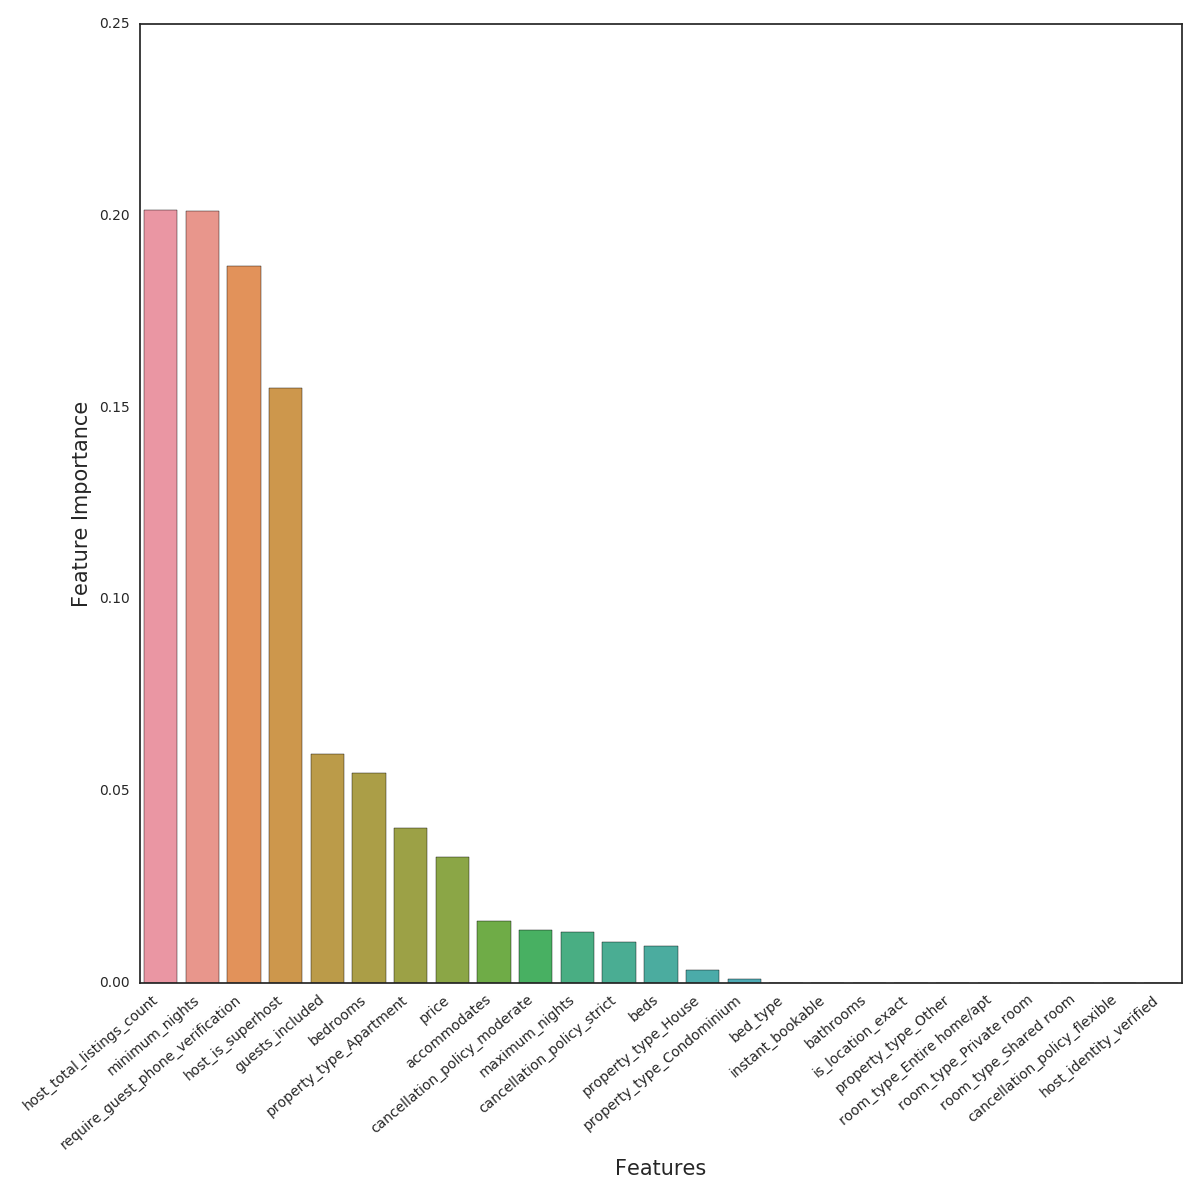

In [114]:
# Plot feature importance of Decision tree regression
plt.figure(figsize =(12,12))
dt_plot = sns.barplot(x="name", y="score", data=dt_feature_df)
dt_plot.set_xticklabels(dt_plot.get_xticklabels(), rotation=40, ha="right")
dt_plot.set_ylabel("Feature Importance", fontsize=15)
dt_plot.set_xlabel("Features", fontsize=15)
plt.tight_layout()
display()

In [115]:
dt_feature_df

Out[ 240 ]: 
 idx name score
1 1 host_total_listings_count 0.201473
11 11 minimum_nights 0.201209
14 14 require_guest_phone_verification 0.186825
0 0 host_is_superhost 0.155126
10 10 guests_included 0.059711
6 6 bedrooms 0.054775
15 15 property_type_Apartment 0.040374
9 9 price 0.032741
4 4 accommodates 0.016032
23 23 cancellation_policy_moderate 0.013808
12 12 maximum_nights 0.013382
24 24 cancellation_policy_strict 0.010722
7 7 beds 0.009478
17 17 property_type_House 0.003456
16 16 property_type_Condominium 0.000888
8 8 bed_type 0.000000
13 13 instant_bookable 0.000000
5 5 bathrooms 0.000000
3 3 is_location_exact 0.000000
18 18 property_type_Other 0.000000
19 19 room_type_Entire home/apt 0.000000
20 20 room_type_Private room 0.000000
21 21 room_type_Shared room 0.000000
22 22 cancellation_policy_flexible 0.000000
2 2 host_identity_verified 0.000000

In [116]:
dt_va_1 = VectorAssembler().setInputCols(['minimum_nights']).setOutputCol('features')
dt_va_2 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification']).setOutputCol('features')
dt_va_3 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost']).setOutputCol('features')
dt_va_4 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights']).setOutputCol('features')
dt_va_5 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count']).setOutputCol('features')
dt_va_6 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count','cancellation_policy_strict']).setOutputCol('features')
dt_va_7 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count','cancellation_policy_strict','guests_included']).setOutputCol('features')
dt_va_8 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count','cancellation_policy_strict','guests_included','accommodates']).setOutputCol('features')
dt_va_9 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count','cancellation_policy_strict','guests_included','accommodates','bedrooms']).setOutputCol('features')
dt_va_10 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count','cancellation_policy_strict','guests_included','accommodates','bedrooms','is_location_exact']).setOutputCol('features')
dt_va_11 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count','cancellation_policy_strict','guests_included','accommodates','bedrooms','is_location_exact','price']).setOutputCol('features')
dt_va_12 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count','cancellation_policy_strict','guests_included','accommodates','bedrooms','is_location_exact','price','instant_bookable']).setOutputCol('features')
dt_va_13 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count','cancellation_policy_strict','guests_included','accommodates','bedrooms','is_location_exact','price','instant_bookable','room_type_Entire home/apt']).setOutputCol('features')
dt_va_14 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count','cancellation_policy_strict','guests_included','accommodates','bedrooms','is_location_exact','price','instant_bookable','room_type_Entire home/apt','cancellation_policy_moderate']).setOutputCol('features')
dt_va_15 = VectorAssembler().setInputCols(['minimum_nights','require_guest_phone_verification','host_is_superhost','maximum_nights','host_total_listings_count','cancellation_policy_strict','guests_included','accommodates','bedrooms','is_location_exact','price','instant_bookable','room_type_Entire home/apt','cancellation_policy_moderate','room_type_Shared room']).setOutputCol('features')



In [117]:
dt_mse_1 = Pipeline(stages = [dt_va_1, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_2 = Pipeline(stages = [dt_va_2, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_3 = Pipeline(stages = [dt_va_3, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_4 = Pipeline(stages = [dt_va_4, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_5 = Pipeline(stages = [dt_va_5, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_6 = Pipeline(stages = [dt_va_6, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_7 = Pipeline(stages = [dt_va_7, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_8 = Pipeline(stages = [dt_va_8, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_9 = Pipeline(stages = [dt_va_9, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_10 = Pipeline(stages = [dt_va_10, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_11 = Pipeline(stages = [dt_va_11, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_12 = Pipeline(stages = [dt_va_12, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_13 = Pipeline(stages = [dt_va_13, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_14 = Pipeline(stages = [dt_va_14, dt]).fit(training_df).transform(validation_df).select(mse)
dt_mse_15 = Pipeline(stages = [dt_va_15, dt]).fit(training_df).transform(validation_df).select(mse)



In [118]:
dt_mse_plot = dt_mse_1.union(dt_mse_2).union(dt_mse_3).union(dt_mse_4).union(dt_mse_5).union(dt_mse_6).union(dt_mse_7).union(dt_mse_8).union(dt_mse_9).union(dt_mse_10).union(dt_mse_11).union(dt_mse_12).union(dt_mse_13).union(dt_mse_14).union(dt_mse_15)

In [119]:
dt_mse_plot.toPandas()

Out[ 244 ]: 
 mse
0 1.457301
1 1.423569
2 1.413066
3 1.396144
4 1.382608
5 1.381632
6 1.389328
7 1.389609
8 1.394470
9 1.394470
10 1.396467
11 1.396467
12 1.396467
13 1.398998
14 1.398998

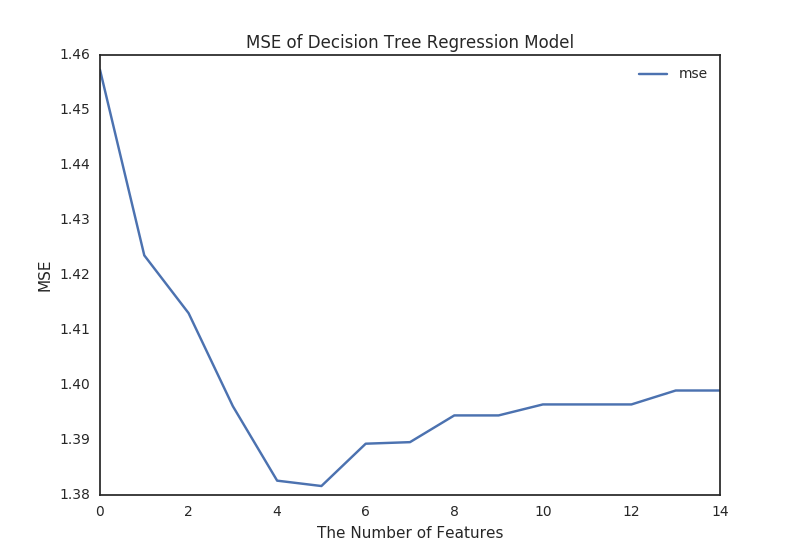

In [120]:
#plot for the DT's mse
dt_mse_plot.toPandas().plot()
plt.xlabel('The Number of Features')
plt.ylabel('MSE')
plt.title('MSE of Decision Tree Regression Model')
display()

In [121]:
treeModel = dt_pipe_model.stages[1]
print(treeModel)

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_28af99769551) of depth 5 with 59 nodes

##Gradient Boosting Regression Model

In [123]:
# Train a GBT model.
gbt = GBTRegressor(featuresCol="features", labelCol='review_scores_value',maxIter=10)

In [124]:
gbt_model = Pipeline(stages = [va, gbt]).fit(training_df)

In [125]:
# Make predictions.
gbt_predictions = gbt_model.transform(validation_df)

In [126]:
gbt_feature_df=ExtractFeatureImp(gbt_model.stages[-1].featureImportances, gbt_predictions, "features")
gbt_feature_df

Out[ 250 ]: 
 idx name score
14 14 require_guest_phone_verification 0.133036
12 12 maximum_nights 0.126762
1 1 host_total_listings_count 0.104155
7 7 beds 0.078851
11 11 minimum_nights 0.077732
10 10 guests_included 0.062824
4 4 accommodates 0.058694
13 13 instant_bookable 0.049553
0 0 host_is_superhost 0.044511
24 24 cancellation_policy_strict 0.037052
9 9 price 0.034568
6 6 bedrooms 0.026783
8 8 bed_type 0.025984
3 3 is_location_exact 0.025326
5 5 bathrooms 0.021830
2 2 host_identity_verified 0.019748
17 17 property_type_House 0.019489
20 20 room_type_Private room 0.010384
22 22 cancellation_policy_flexible 0.010146
23 23 cancellation_policy_moderate 0.009257
19 19 room_type_Entire home/apt 0.005923
16 16 property_type_Condominium 0.004727
21 21 room_type_Shared room 0.004316
18 18 property_type_Other 0.004313
15 15 property_type_Apartment 0.004037

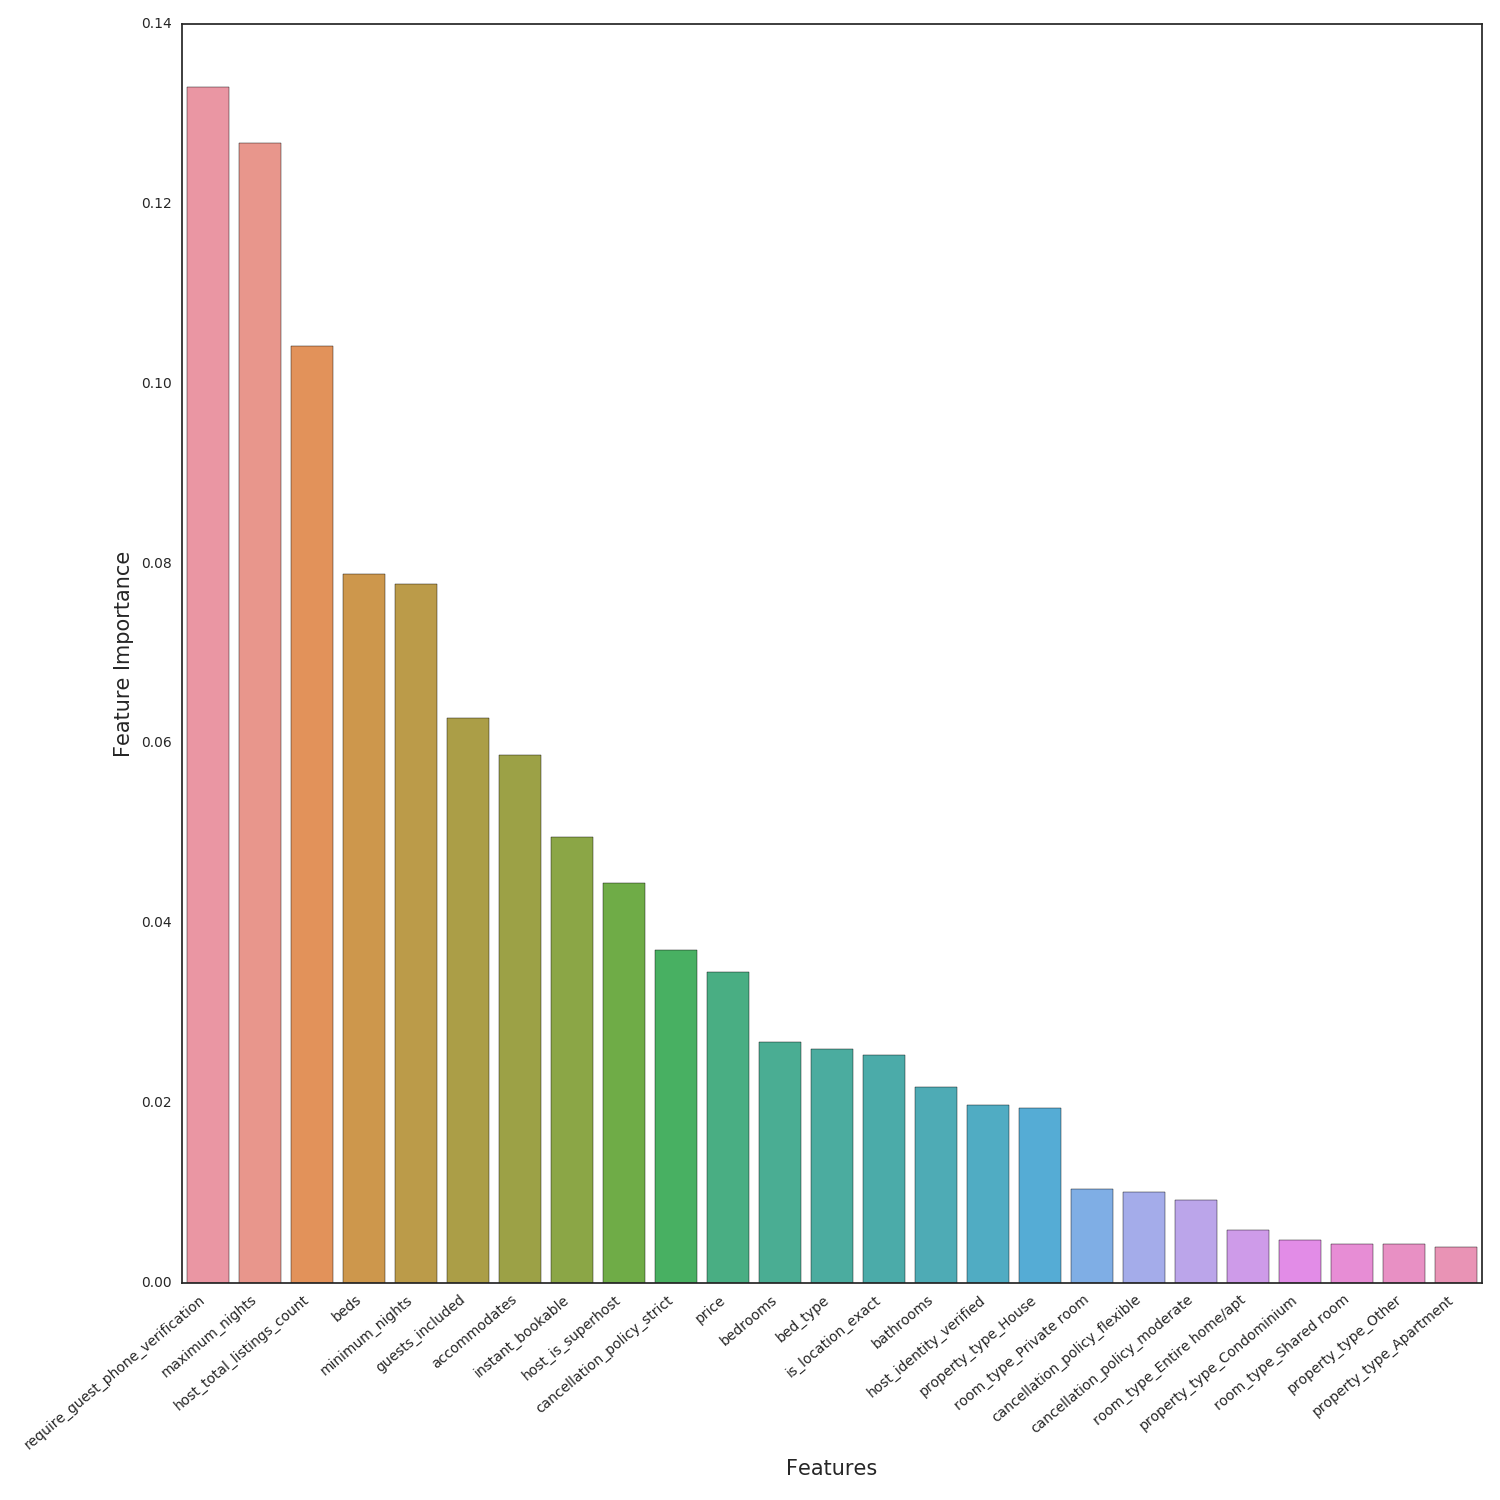

In [127]:
plt.figure(figsize =(15,15))

gbt_plot = sns.barplot(x="name", y="score", data=gbt_feature_df)
gbt_plot.set_xticklabels(gbt_plot.get_xticklabels(), rotation=40, ha="right")
gbt_plot.set_ylabel("Feature Importance", fontsize=15)
gbt_plot.set_xlabel("Features", fontsize=15)
plt.tight_layout()
display()


In [128]:
gbt_feature_df

Out[ 252 ]: 
 idx name score
14 14 require_guest_phone_verification 0.133036
12 12 maximum_nights 0.126762
1 1 host_total_listings_count 0.104155
7 7 beds 0.078851
11 11 minimum_nights 0.077732
10 10 guests_included 0.062824
4 4 accommodates 0.058694
13 13 instant_bookable 0.049553
0 0 host_is_superhost 0.044511
24 24 cancellation_policy_strict 0.037052
9 9 price 0.034568
6 6 bedrooms 0.026783
8 8 bed_type 0.025984
3 3 is_location_exact 0.025326
5 5 bathrooms 0.021830
2 2 host_identity_verified 0.019748
17 17 property_type_House 0.019489
20 20 room_type_Private room 0.010384
22 22 cancellation_policy_flexible 0.010146
23 23 cancellation_policy_moderate 0.009257
19 19 room_type_Entire home/apt 0.005923
16 16 property_type_Condominium 0.004727
21 21 room_type_Shared room 0.004316
18 18 property_type_Other 0.004313
15 15 property_type_Apartment 0.004037

In [129]:
gbt_va1 = VectorAssembler().setInputCols(['maximum_nights']).setOutputCol('features')
gbt_va2 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count']).setOutputCol('features')
gbt_va3 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates']).setOutputCol('features')
gbt_va4 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification']).setOutputCol('features')
gbt_va5 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms']).setOutputCol('features')
gbt_va6 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms','minimum_nights']).setOutputCol('features')
gbt_va7 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms','minimum_nights','host_identity_verified']).setOutputCol('features')
gbt_va8 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms','minimum_nights','host_identity_verified','beds']).setOutputCol('features')
gbt_va9 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms','minimum_nights','host_identity_verified','beds','price']).setOutputCol('features')
gbt_va10 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms','minimum_nights','host_identity_verified','beds','price',
'guests_included']).setOutputCol('features')
gbt_va11 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms','minimum_nights','host_identity_verified','beds','price',
'guests_included','bedrooms']).setOutputCol('features')
gbt_va12 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms','minimum_nights','host_identity_verified','beds','price',
'guests_included','bedrooms','cancellation_policy_flexible']).setOutputCol('features')
gbt_va13 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms','minimum_nights','host_identity_verified','beds','price',
'guests_included','bedrooms','cancellation_policy_flexible']).setOutputCol('features')
gbt_va14 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms','minimum_nights','host_identity_verified','beds','price',
'guests_included','bedrooms','cancellation_policy_flexible','host_is_superhost']).setOutputCol('features')
gbt_va15 = VectorAssembler().setInputCols(['maximum_nights','host_total_listings_count','accommodates','require_guest_phone_verification','bathrooms','minimum_nights','host_identity_verified','beds','price',
'guests_included','bedrooms','cancellation_policy_flexible','host_is_superhost','cancellation_policy_strict']).setOutputCol('features')


In [130]:

gbt_model_1 = Pipeline(stages = [gbt_va1, dt]).fit(training_df)
gbt_model_2 = Pipeline(stages = [gbt_va2, dt]).fit(training_df)
gbt_model_3 = Pipeline(stages = [gbt_va3, dt]).fit(training_df)
gbt_model_4 = Pipeline(stages = [gbt_va4, dt]).fit(training_df)
gbt_model_5 = Pipeline(stages = [gbt_va5, dt]).fit(training_df)
gbt_model_6 = Pipeline(stages = [gbt_va6, dt]).fit(training_df)
gbt_model_7 = Pipeline(stages = [gbt_va7, dt]).fit(training_df)
gbt_model_8 = Pipeline(stages = [gbt_va8, dt]).fit(training_df)
gbt_model_9 = Pipeline(stages = [gbt_va9, dt]).fit(training_df)
gbt_model_10 = Pipeline(stages = [gbt_va10, dt]).fit(training_df)
gbt_model_11 = Pipeline(stages = [gbt_va11, dt]).fit(training_df)
gbt_model_12 = Pipeline(stages = [gbt_va12, dt]).fit(training_df)
gbt_model_13 = Pipeline(stages = [gbt_va13, dt]).fit(training_df)
gbt_model_14 = Pipeline(stages = [gbt_va14, dt]).fit(training_df)
gbt_model_15 = Pipeline(stages = [gbt_va15, dt]).fit(training_df)



In [131]:
gbt_predictions1 = gbt_model_1.transform(validation_df)
gbt_predictions2 = gbt_model_2.transform(validation_df)
gbt_predictions3 = gbt_model_3.transform(validation_df)
gbt_predictions4 = gbt_model_4.transform(validation_df)
gbt_predictions5 = gbt_model_5.transform(validation_df)
gbt_predictions6 = gbt_model_6.transform(validation_df)
gbt_predictions7 = gbt_model_7.transform(validation_df)
gbt_predictions8 = gbt_model_8.transform(validation_df)
gbt_predictions9 = gbt_model_9.transform(validation_df)
gbt_predictions10 = gbt_model_10.transform(validation_df)
gbt_predictions11 = gbt_model_11.transform(validation_df)
gbt_predictions12 = gbt_model_12.transform(validation_df)
gbt_predictions13 = gbt_model_13.transform(validation_df)
gbt_predictions14 = gbt_model_13.transform(validation_df)
gbt_predictions15 = gbt_model_13.transform(validation_df)




In [132]:
gbt_mse1 = gbt_model_1.transform(validation_df).select(mse)
gbt_mse2 = gbt_model_2.transform(validation_df).select(mse)
gbt_mse3 = gbt_model_3.transform(validation_df).select(mse)
gbt_mse4 = gbt_model_4.transform(validation_df).select(mse)
gbt_mse5 = gbt_model_5.transform(validation_df).select(mse)
gbt_mse6 = gbt_model_6.transform(validation_df).select(mse)
gbt_mse7 = gbt_model_7.transform(validation_df).select(mse)
gbt_mse8 = gbt_model_8.transform(validation_df).select(mse)
gbt_mse9 = gbt_model_9.transform(validation_df).select(mse)
gbt_mse10 = gbt_model_10.transform(validation_df).select(mse)
gbt_mse11 = gbt_model_11.transform(validation_df).select(mse)
gbt_mse12 = gbt_model_12.transform(validation_df).select(mse)
gbt_mse13 = gbt_model_13.transform(validation_df).select(mse)
gbt_mse14 = gbt_model_14.transform(validation_df).select(mse)
gbt_mse15 = gbt_model_15.transform(validation_df).select(mse)

In [133]:
gbt_mse_plot = gbt_mse1.union(gbt_mse2).union(gbt_mse3).union(gbt_mse4).union(gbt_mse5).union(gbt_mse6).union(gbt_mse7).union(gbt_mse8).union(gbt_mse9).union(gbt_mse10).union(gbt_mse11).union(gbt_mse12).union(gbt_mse13).union(gbt_mse14).union(gbt_mse15)

In [134]:
gbt_mse_plot.toPandas()

Out[ 258 ]: 
 mse
0 1.439674
1 1.413444
2 1.413681
3 1.397976
4 1.406655
5 1.411604
6 1.411604
7 1.409455
8 1.408296
9 1.403306
10 1.411889
11 1.411889
12 1.411889
13 1.398025
14 1.396592

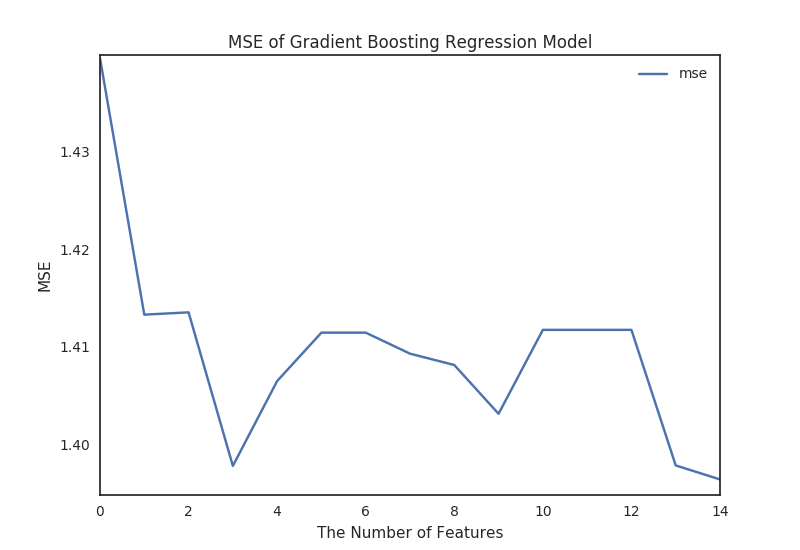

In [135]:
#plot for the DT's mse
gbt_mse_plot.toPandas().plot()
plt.xlabel('The Number of Features')
plt.ylabel('MSE')
plt.title('MSE of Gradient Boosting Regression Model')
display()

In [136]:
# Interpretation
getGBTModel = gbt_model.stages[1]
print(getGBTModel) 

GBTRegressionModel (uid=GBTRegressor_045b521c2dc7) with 10 trees

## Random Forest Regression

In [138]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features',labelCol='review_scores_value')

In [139]:
# Chain indexer and forest in a Pipeline
rf_pipe_model = Pipeline(stages=[va, rf]).fit(training_df)


In [140]:
rf_pipe_model_predictions = rf_pipe_model.transform(validation_df)


In [141]:
rf_feature_df = ExtractFeatureImp(rf_pipe_model.stages[-1].featureImportances, rf_pipe_model_predictions, "features")
rf_feature_df

Out[ 264 ]: 
 idx name score
1 1 host_total_listings_count 0.180759
14 14 require_guest_phone_verification 0.172253
11 11 minimum_nights 0.165042
0 0 host_is_superhost 0.152115
12 12 maximum_nights 0.059330
24 24 cancellation_policy_strict 0.043318
10 10 guests_included 0.043167
4 4 accommodates 0.033499
9 9 price 0.026141
6 6 bedrooms 0.024521
7 7 beds 0.012934
5 5 bathrooms 0.012420
2 2 host_identity_verified 0.010735
22 22 cancellation_policy_flexible 0.010100
23 23 cancellation_policy_moderate 0.008717
19 19 room_type_Entire home/apt 0.006863
17 17 property_type_House 0.006712
8 8 bed_type 0.006097
20 20 room_type_Private room 0.005551
13 13 instant_bookable 0.004879
21 21 room_type_Shared room 0.003922
16 16 property_type_Condominium 0.003348
15 15 property_type_Apartment 0.002852
18 18 property_type_Other 0.002752
3 3 is_location_exact 0.001973

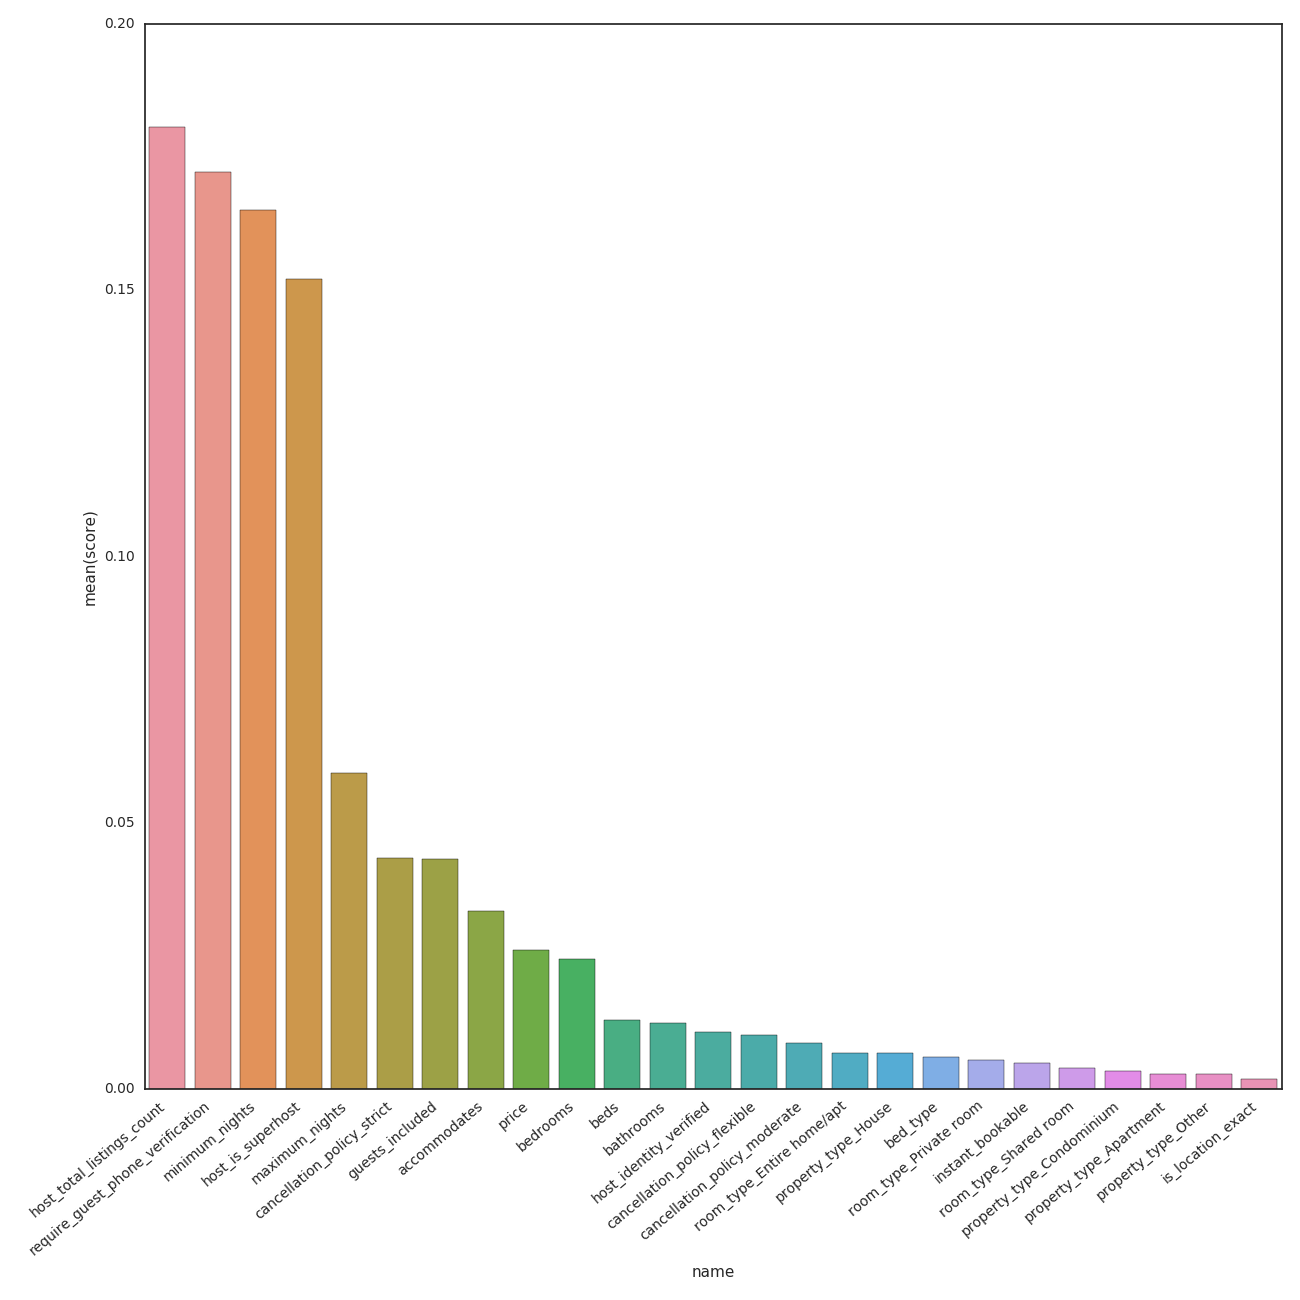

In [142]:
plt.figure(figsize =(13,13))

rf_plot = sns.barplot(x="name", y="score", data=rf_feature_df)
rf_plot.set_xticklabels(rf_plot.get_xticklabels(), rotation=40, ha="right")
gbt_plot.set_ylabel("Feature Importance", fontsize=15)
gbt_plot.set_xlabel("Features", fontsize=15)
plt.tight_layout()
display()

In [143]:
rf_feature_df

Out[ 266 ]: 
 idx name score
1 1 host_total_listings_count 0.180759
14 14 require_guest_phone_verification 0.172253
11 11 minimum_nights 0.165042
0 0 host_is_superhost 0.152115
12 12 maximum_nights 0.059330
24 24 cancellation_policy_strict 0.043318
10 10 guests_included 0.043167
4 4 accommodates 0.033499
9 9 price 0.026141
6 6 bedrooms 0.024521
7 7 beds 0.012934
5 5 bathrooms 0.012420
2 2 host_identity_verified 0.010735
22 22 cancellation_policy_flexible 0.010100
23 23 cancellation_policy_moderate 0.008717
19 19 room_type_Entire home/apt 0.006863
17 17 property_type_House 0.006712
8 8 bed_type 0.006097
20 20 room_type_Private room 0.005551
13 13 instant_bookable 0.004879
21 21 room_type_Shared room 0.003922
16 16 property_type_Condominium 0.003348
15 15 property_type_Apartment 0.002852
18 18 property_type_Other 0.002752
3 3 is_location_exact 0.001973

In [144]:
rf_va1 = VectorAssembler().setInputCols(['host_total_listings_count']).setOutputCol('features')
rf_va2 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification']).setOutputCol('features')
rf_va3 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost']).setOutputCol('features')
rf_va4 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights']).setOutputCol('features')
rf_va5 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights']).setOutputCol('features')
rf_va6 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict']).setOutputCol('features')
rf_va7 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict','accommodates']).setOutputCol('features')
rf_va8 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict','accommodates','price']).setOutputCol('features')
rf_va9 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict','accommodates','price','beds']).setOutputCol('features')
rf_va10 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict','accommodates','price','beds','guests_included']).setOutputCol('features')
rf_va11 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict','accommodates','price','beds','guests_included','cancellation_policy_flexible']).setOutputCol('features')
rf_va12 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict','accommodates','price','beds','guests_included','cancellation_policy_flexible','host_identity_verified']).setOutputCol('features')
rf_va13 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict','accommodates','price','beds','guests_included','cancellation_policy_flexible','host_identity_verified','bathrooms']).setOutputCol('features')
rf_va14 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict','accommodates','price','beds','guests_included','cancellation_policy_flexible','host_identity_verified','bathrooms','bedrooms']).setOutputCol('features')
rf_va15 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict','accommodates','price','beds','guests_included','cancellation_policy_flexible','host_identity_verified','bathrooms','bedrooms','property_type_Condominium']).setOutputCol('features')
rf_va16 = VectorAssembler().setInputCols(['host_total_listings_count','require_guest_phone_verification','host_is_superhost','minimum_nights','maximum_nights','cancellation_policy_strict','accommodates','price','beds','guests_included','cancellation_policy_flexible','host_identity_verified','bathrooms','bedrooms','property_type_Condominium','property_type_Apartment']).setOutputCol('features')



In [145]:
rf_mse_1 = Pipeline(stages = [rf_va1, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_2 = Pipeline(stages = [rf_va2, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_3 = Pipeline(stages = [rf_va3, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_4 = Pipeline(stages = [rf_va4, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_5 = Pipeline(stages = [rf_va5, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_6 = Pipeline(stages = [rf_va6, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_7 = Pipeline(stages = [rf_va7, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_8 = Pipeline(stages = [rf_va8, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_9 = Pipeline(stages = [rf_va9, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_10 = Pipeline(stages = [rf_va10, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_11 = Pipeline(stages = [rf_va11, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_12 = Pipeline(stages = [rf_va12, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_13 = Pipeline(stages = [rf_va13, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_14 = Pipeline(stages = [rf_va14, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_15 = Pipeline(stages = [rf_va15, dt]).fit(training_df).transform(validation_df).select(mse)
rf_mse_16 = Pipeline(stages = [rf_va16, dt]).fit(training_df).transform(validation_df).select(mse)



In [146]:
rf_mse_plot = rf_mse_1.union(rf_mse_2).union(rf_mse_3).union(rf_mse_4).union(rf_mse_5).union(rf_mse_6).union(rf_mse_7).union(rf_mse_8).union(rf_mse_9).union(rf_mse_10).union(rf_mse_11).union(rf_mse_12).union(rf_mse_13).union(rf_mse_14).union(rf_mse_15).union(rf_mse_16)

In [147]:
rf_mse_plot.toPandas()

Out[ 270 ]: 
 mse
0 1.445186
1 1.415765
2 1.392341
3 1.393700
4 1.382608
5 1.381632
6 1.389548
7 1.390269
8 1.389418
9 1.390900
10 1.390900
11 1.390900
12 1.388009
13 1.396592
14 1.396718
15 1.401723

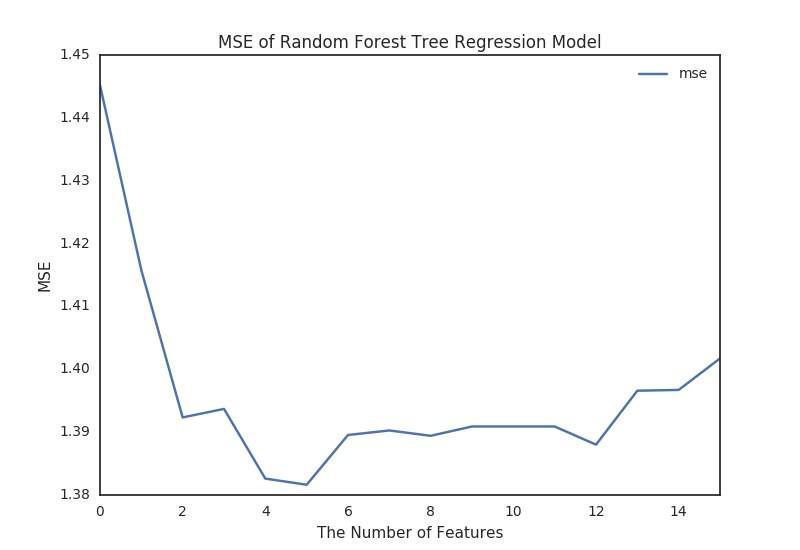

In [148]:
#plot for the RF's mse

rf_mse_plot1 =rf_mse_plot.toPandas().plot()

plt.xlabel('The Number of Features')
plt.ylabel('MSE')
plt.title('MSE of Random Forest Tree Regression Model')
display()

In [149]:
rf_pipe_model.transform(validation_df).select(mse).show()

+------------------+
 mse|
+------------------+
1.3860856924657212|
+------------------+

In [150]:
rfModel = rf_pipe_model.stages[1]
print(rfModel)  # summary only

RandomForestRegressionModel (uid=RandomForestRegressor_142b7f4ce4df) with 20 trees

## Best Model for each Regression Model after future selection

In [152]:
#1) Linear Moedel 14 : mse
best_lr_model = Pipeline(stages = [lr_va14, lr]).fit(training_df).transform(validation_df).select(mse).show()

#2) Decision Tree 6 : mse
best_dt_mse_ = Pipeline(stages = [dt_va_6, dt]).fit(training_df).transform(validation_df).select(mse).show()


#3) Gradient Boost 6 : mse
best_gbt_model = Pipeline(stages = [gbt_va6, dt]).fit(training_df).transform(validation_df).select(mse).show()


#4) Random Forest 6 : mse
best_rf_model = Pipeline(stages = [rf_va6, dt]).fit(training_df).transform(validation_df).select(mse).show()

+-----------------+
 mse|
+-----------------+
1.408481400799933|
+-----------------+

+------------------+
 mse|
+------------------+
1.3816322110131298|
+------------------+

+------------------+
 mse|
+------------------+
1.4116044431832018|
+------------------+

+------------------+
 mse|
+------------------+
1.3816322110131298|
+------------------+

##Parameter tuning

## Linear Regression model parameter tuning

In [155]:
Elasticnetparam = [0.1,0.2,0.3,0.5,0.6]
Regparam = [0.01,0.02,0.03,0.04]
for elasticnetparam in Elasticnetparam:
  for regparam in Regparam: 
    Pipeline(stages=[lr_va14,LinearRegression(featuresCol='features',labelCol='review_scores_value').setElasticNetParam(elasticnetparam).setRegParam(regparam)]).fit(training_df).transform(validation_df).select(mse).show()
    print("ElasticNet mixing parameter", elasticnetparam)
    print('regularization parameter', regparam)

+------------------+
 mse|
+------------------+
1.4086275425438464|
+------------------+

ElasticNet mixing parameter 0.1
regularization parameter 0.01
+-----------------+
 mse|
+-----------------+
1.408808786796918|
+-----------------+

ElasticNet mixing parameter 0.1
regularization parameter 0.02
+------------------+
 mse|
+------------------+
1.4090260067282114|
+------------------+

ElasticNet mixing parameter 0.1
regularization parameter 0.03
+-----------------+
 mse|
+-----------------+
1.409280109617453|
+-----------------+

ElasticNet mixing parameter 0.1
regularization parameter 0.04
+------------------+
 mse|
+------------------+
1.4087026034723218|
+------------------+

ElasticNet mixing parameter 0.2
regularization parameter 0.01
+------------------+
 mse|
+------------------+
1.4090219611151338|
+------------------+

ElasticNet mixing parameter 0.2
regularization parameter 0.02
+------------------+
 mse|
+------------------+
1.4094460499278934|
+------------------+

ElasticNet mixing parameter 0.2
regularization parameter 0.03
+------------------+
 mse|
+------------------+
1.4099704854051258|
+------------------+

ElasticNet mixing parameter 0.2
regularization parameter 0.04
+-----------------+
 mse|
+-----------------+
1.408792653071773|
+-----------------+

ElasticNet mixing parameter 0.3
regularization parameter 0.01
+-----------------+
 mse|
+-----------------+
1.409305882760933|
+-----------------+

ElasticNet mixing parameter 0.3
regularization parameter 0.02
+------------------+
 mse|
+------------------+
1.4100243334553508|
+------------------+

ElasticNet mixing parameter 0.3
regularization parameter 0.03
+------------------+
 mse|
+------------------+
1.4109160306087831|
+------------------+

ElasticNet mixing parameter 0.3
regularization parameter 0.04
+------------------+
 mse|
+------------------+
1.4090264619750936|
+------------------+

ElasticNet mixing parameter 0.5
regularization parameter 0.01
+------------------+
 mse|
+------------------+
1.4100889866124287|
+------------------+

ElasticNet mixing parameter 0.5
regularization parameter 0.02
+------------------+
 mse|
+------------------+
1.4114648790407123|
+------------------+

ElasticNet mixing parameter 0.5
regularization parameter 0.03
+------------------+
 mse|
+------------------+
1.4130641225708747|
+------------------+

ElasticNet mixing parameter 0.5
regularization parameter 0.04
+------------------+
 mse|
+------------------+
1.4091704424407618|
+------------------+

ElasticNet mixing parameter 0.6
regularization parameter 0.01
+------------------+
 mse|
+------------------+
1.4105632988178147|
+------------------+

ElasticNet mixing parameter 0.6
regularization parameter 0.02
+------------------+
 mse|
+------------------+
1.4122640707361087|
+------------------+

ElasticNet mixing parameter 0.6
regularization parameter 0.03
+------------------+
 mse|
+------------------+
1.4142268412139978|
+------------------+

ElasticNet mixing parameter 0.6
regularization parameter 0.04

## Decision Tree Regression model parameter tuning

In [157]:
for maxbins in list(range(2,10,3)):
  for maxdepth in list(range(1,10,2)): 
    Pipeline(stages=[dt_va_6,DecisionTreeRegressor(featuresCol='features',labelCol='review_scores_value').setMaxDepth(maxdepth).setMaxBins(maxbins)]).fit(training_df).transform(validation_df).select(mse).show()
    print("max bins of tress", maxbins)
    print('max depth of trees', maxdepth)

+------------------+
 mse|
+------------------+
1.4424069849469263|
+------------------+

max bins of tress 2
max depth of trees 1
+-----------------+
 mse|
+-----------------+
1.406709807658616|
+-----------------+

max bins of tress 2
max depth of trees 3
+-----------------+
 mse|
+-----------------+
1.398994927326619|
+-----------------+

max bins of tress 2
max depth of trees 5
+------------------+
 mse|
+------------------+
1.4041022387007718|
+------------------+

max bins of tress 2
max depth of trees 7
+------------------+
 mse|
+------------------+
1.4041022387007718|
+------------------+

max bins of tress 2
max depth of trees 9
+------------------+
 mse|
+------------------+
1.4585501975012012|
+------------------+

max bins of tress 5
max depth of trees 1
+-----------------+
 mse|
+-----------------+
1.406232020629436|
+-----------------+

max bins of tress 5
max depth of trees 3
+------------------+
 mse|
+------------------+
1.3864091138183965|
+------------------+

max bins of tress 5
max depth of trees 5
+------------------+
 mse|
+------------------+
1.3704246974232241|
+------------------+

max bins of tress 5
max depth of trees 7
+------------------+
 mse|
+------------------+
1.3776751634893476|
+------------------+

max bins of tress 5
max depth of trees 9
+------------------+
 mse|
+------------------+
1.4585501975012012|
+------------------+

max bins of tress 8
max depth of trees 1
+------------------+
 mse|
+------------------+
1.4062756775372516|
+------------------+

max bins of tress 8
max depth of trees 3
+------------------+
 mse|
+------------------+
1.3839433138824184|
+------------------+

max bins of tress 8
max depth of trees 5
+------------------+
 mse|
+------------------+
1.3781327383190107|
+------------------+

max bins of tress 8
max depth of trees 7
+------------------+
 mse|
+------------------+
1.3892174856968915|
+------------------+

max bins of tress 8
max depth of trees 9

## Gradient Boost regression model parameter tuning

In [159]:
for maxiter in list(range(2,11,2)):
  for maxdepth in list(range(2,10,2)): 
    Pipeline(stages=[gbt_va6,GBTRegressor(featuresCol='features',labelCol='review_scores_value').setMaxDepth(maxdepth).setMaxIter(maxiter)]).fit(training_df).transform(validation_df).select(mse).show()
    print("max iteration of tress", maxiter)
    print('max depth of trees', maxdepth)

+-----------------+
 mse|
+-----------------+
1.420483024572566|
+-----------------+

max iteration of tress 2
max depth of trees 2
+------------------+
 mse|
+------------------+
1.4082070828089928|
+------------------+

max iteration of tress 2
max depth of trees 4
+------------------+
 mse|
+------------------+
1.4108163413421013|
+------------------+

max iteration of tress 2
max depth of trees 6
+------------------+
 mse|
+------------------+
1.4559174099146879|
+------------------+

max iteration of tress 2
max depth of trees 8
+------------------+
 mse|
+------------------+
1.4153570325277087|
+------------------+

max iteration of tress 4
max depth of trees 2
+-----------------+
 mse|
+-----------------+
1.404626829975752|
+-----------------+

max iteration of tress 4
max depth of trees 4
+------------------+
 mse|
+------------------+
1.4088696118153992|
+------------------+

max iteration of tress 4
max depth of trees 6
+------------------+
 mse|
+------------------+
1.4591736033753373|
+------------------+

max iteration of tress 4
max depth of trees 8
+------------------+
 mse|
+------------------+
1.4110887906827014|
+------------------+

max iteration of tress 6
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3991820199845817|
+------------------+

max iteration of tress 6
max depth of trees 4
+------------------+
 mse|
+------------------+
1.4070596379066578|
+------------------+

max iteration of tress 6
max depth of trees 6
+------------------+
 mse|
+------------------+
1.4619114233751473|
+------------------+

max iteration of tress 6
max depth of trees 8
+-----------------+
 mse|
+-----------------+
1.409372524657834|
+-----------------+

max iteration of tress 8
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3956955699500837|
+------------------+

max iteration of tress 8
max depth of trees 4
+------------------+
 mse|
+------------------+
1.4068959297805563|
+------------------+

max iteration of tress 8
max depth of trees 6
+------------------+
 mse|
+------------------+
1.4638561660731626|
+------------------+

max iteration of tress 8
max depth of trees 8
+------------------+
 mse|
+------------------+
1.4047562379225005|
+------------------+

max iteration of tress 10
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3932473110844437|
+------------------+

max iteration of tress 10
max depth of trees 4
+-----------------+
 mse|
+-----------------+
1.411918479959138|
+-----------------+

max iteration of tress 10
max depth of trees 6
+------------------+
 mse|
+------------------+
1.4654990649638218|
+------------------+

max iteration of tress 10
max depth of trees 8

##Random Forest regression model parameter tuning

In [161]:
for numOfTrees in list(range(1,200,20)):
  for maxdepth in list(range(2,10,2)): 
    Pipeline(stages=[rf_va6,RandomForestRegressor(featuresCol='features',labelCol='review_scores_value').setNumTrees(numOfTrees).setMaxDepth(maxdepth)]).fit(training_df).transform(validation_df).select(mse).show()
    print("number of tress", numOfTrees)
    print('max depth of trees', maxdepth)

+------------------+
 mse|
+------------------+
1.4264616384360689|
+------------------+

number of tress 1
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3916544884595257|
+------------------+

number of tress 1
max depth of trees 4
+------------------+
 mse|
+------------------+
1.3712137772769637|
+------------------+

number of tress 1
max depth of trees 6
+------------------+
 mse|
+------------------+
1.3768853583659435|
+------------------+

number of tress 1
max depth of trees 8
+------------------+
 mse|
+------------------+
1.4121831511908407|
+------------------+

number of tress 21
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3880667852944057|
+------------------+

number of tress 21
max depth of trees 4
+----------------+
 mse|
+----------------+
1.37544215497232|
+----------------+

number of tress 21
max depth of trees 6
+------------------+
 mse|
+------------------+
1.3683958848567936|
+------------------+

number of tress 21
max depth of trees 8
+------------------+
 mse|
+------------------+
1.4184120206095452|
+------------------+

number of tress 41
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3880065286955312|
+------------------+

number of tress 41
max depth of trees 4
+------------------+
 mse|
+------------------+
1.3716828194464268|
+------------------+

number of tress 41
max depth of trees 6
+------------------+
 mse|
+------------------+
1.3643866727420342|
+------------------+

number of tress 41
max depth of trees 8
+-----------------+
 mse|
+-----------------+
1.415623691879348|
+-----------------+

number of tress 61
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3871340388709625|
+------------------+

number of tress 61
max depth of trees 4
+------------------+
 mse|
+------------------+
1.3718140350773937|
+------------------+

number of tress 61
max depth of trees 6
+------------------+
 mse|
+------------------+
1.3643515264909225|
+------------------+

number of tress 61
max depth of trees 8
+------------------+
 mse|
+------------------+
1.4149708680579605|
+------------------+

number of tress 81
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3861700687381175|
+------------------+

number of tress 81
max depth of trees 4
+------------------+
 mse|
+------------------+
1.3742350886124794|
+------------------+

number of tress 81
max depth of trees 6
+-----------------+
 mse|
+-----------------+
1.366311199531469|
+-----------------+

number of tress 81
max depth of trees 8
+------------------+
 mse|
+------------------+
1.4155761618041585|
+------------------+

number of tress 101
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3888865294387374|
+------------------+

number of tress 101
max depth of trees 4
+-----------------+
 mse|
+-----------------+
1.375464228710367|
+-----------------+

number of tress 101
max depth of trees 6
+------------------+
 mse|
+------------------+
1.3676166665524756|
+------------------+

number of tress 101
max depth of trees 8
+------------------+
 mse|
+------------------+
1.4164161467892575|
+------------------+

number of tress 121
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3888915153630825|
+------------------+

number of tress 121
max depth of trees 4
+------------------+
 mse|
+------------------+
1.3724754136259607|
+------------------+

number of tress 121
max depth of trees 6
+------------------+
 mse|
+------------------+
1.3648529314343085|
+------------------+

number of tress 121
max depth of trees 8
+-----------------+
 mse|
+-----------------+
1.415428788815584|
+-----------------+

number of tress 141
max depth of trees 2
+------------------+
 mse|
+------------------+
1.3869069501421096|
+------------------+

number of tress 141
max depth of trees 4
+------------------+
 mse|
+------------------+
1.3716771317290564|
+------------------+

number of tress 141
max dept

## best model after feature selection and parameter tuning

In [163]:
#1) Linear Moedel 14 : mse
final_best_lr_model = Pipeline(stages=[lr_va14,LinearRegression(featuresCol='features',labelCol='review_scores_value').setElasticNetParam(0.1).setRegParam(0.01)]).fit(training_df).transform(testing_df).select(mse).show()

#2) Decision Tree 6 : mse
final_best_dt_model = Pipeline(stages=[dt_va_6,DecisionTreeRegressor(featuresCol='features',labelCol='review_scores_value').setMaxDepth(8).setMaxBins(5)]).fit(training_df).transform(testing_df).select(mse).show()
getDTModel = final_best_dt_model.stages[1]
print(getGBTModel) 

#3) Gradient Boost 6 : mse
final_best_gbt_model = Pipeline(stages=[gbt_va6,GBTRegressor(featuresCol='features',labelCol='review_scores_value').setMaxDepth(8).setMaxIter(8)]).fit(training_df).transform(testing_df).select(mse).show()
getGBTModel = final_best_gbt_model.stages[1]
print(getGBTModel) 

#4) Random Forest 6 : mse
final_best_rf_model =  Pipeline(stages=[rf_va6,RandomForestRegressor(featuresCol='features',labelCol='review_scores_value').setNumTrees(181).setMaxDepth(8)]).fit(training_df).transform(testing_df).select(mse).show()

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-3773404263759584> in <module> () 
 4 #2) Decision Tree 6 : mse 
 5 final_best_dt_mse_ = Pipeline ( stages = [ dt_va_6 , DecisionTreeRegressor ( featuresCol = 'features' , labelCol = 'review_scores_value' ) . setMaxDepth ( 8 ) . setMaxBins ( 5 ) ] ) . fit ( training_df ) . transform ( testing_df ) . select ( mse ) . show ( ) 
 ----> 6 getDTModel = final_best_gbt_model . stages [ 1 ] 
 7 print ( getGBTModel ) 
 8 

 AttributeError : 'NoneType' object has no attribute 'stages'

#Residual plot

In [165]:
residual = (fn.col('review_scores_value') - fn.col('prediction')).alias('residual')

In [166]:
#1)Linear Model
fig, ax = plt.subplots()
ax.scatter(validation_df.select('review_scores_value').collect(), lr_model_14.transform(validation_df).select(residual).collect())
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()
display()

In [167]:
#2)D.T Model
fig, ax = plt.subplots()
ax.scatter(validation_df.select('review_scores_value').collect(), Pipeline(stages = [dt_va_6, dt]).fit(training_df).transform(validation_df).select(residual).collect())
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()
display()

In [168]:
#3)G.B Model
fig, ax = plt.subplots()
ax.scatter(validation_df.select('review_scores_value').collect(), gbt_model_6.transform(validation_df).select(residual).collect())
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()
display()

In [169]:
#4)R.F Model
fig, ax = plt.subplots()
ax.scatter(validation_df.select('review_scores_value').collect(), Pipeline(stages = [rf_va6, dt]).fit(training_df).transform(validation_df).select(residual).collect())
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()
display()